# 1. CatBoost Baseline

In [1]:
!pip install tree-sitter \
  tree-sitter-python tree-sitter-java tree-sitter-cpp tree-sitter-c \
  tree-sitter-go tree-sitter-php tree-sitter-c-sharp tree-sitter-javascript

In [8]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.9/554.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [shap]


In [1]:
import pandas as pd
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    classification_report, ConfusionMatrixDisplay,
    PrecisionRecallDisplay
)
import matplotlib.pyplot as plt
import shap
from catboost import Pool
from tree_sitter import Parser, Language
import math
from tqdm import tqdm
import numpy as np
import re
import tree_sitter_python
import tree_sitter_java
import tree_sitter_cpp
import tree_sitter_c
import tree_sitter_go
import tree_sitter_php
import tree_sitter_c_sharp
import tree_sitter_javascript
import json

In [2]:
# Tree-sitter language objects for each language
# These are used to create parsers for AST based feature extraction
LANGUAGES = {
    "python": Language(tree_sitter_python.language()),
    "java": Language(tree_sitter_java.language()),
    "cpp": Language(tree_sitter_cpp.language()),
    "c": Language(tree_sitter_c.language()),
    "go": Language(tree_sitter_go.language()),
    "php": Language(tree_sitter_php.language_php()),
    "csharp": Language(tree_sitter_c_sharp.language()),
    "javascript": Language(tree_sitter_javascript.language())
}

# Create one parser per language and store them in a dictionary
PARSERS = {}
for name, lang_obj in LANGUAGES.items():
    p = Parser()
    p.language = lang_obj # Attach the language grammar to this parser
    PARSERS[name] = p

# Used for language detection by evaluating how well a parser understands the code
# Fewer ERROR nodes indicate a better match
def count_error_nodes(root) -> int:
    """
    Counts how many ERROR nodes appear in the parsed tree.
    """
    err = 0
    stack = [root] # Stack used for iterative depth first traversal
    while stack:
        n = stack.pop()
        if n.type == "ERROR":
            err += 1
        stack.extend(n.children) # Visit children to continue scanning the whole tree
    return err

def detect_language_by_best_parse(code: str, candidates=None) -> str:
    """
    Detects the programming language by parsing with each candidate parser
    and choosing the language with the fewest ERROR nodes.
    """
    if candidates is None:
        candidates = list(PARSERS.keys())

    best_lang = candidates[0]
    best_err = None
    b = code.encode("utf8", errors="ignore") # Encode once because Tree-sitter expects bytes

    for lang in candidates:
        try:
            # Parse code using this language parser
            tree = PARSERS[lang].parse(b)

            # Count how many ERROR nodes the parser produced
            err = count_error_nodes(tree.root_node)

            # Keep the language that gives the smallest number of errors
            if best_err is None or err < best_err:
                best_err = err
                best_lang = lang
        except Exception:
            continue

    return best_lang

def max_depth(root) -> int:
    """
    Computes the maximum depth of the AST.
    Root is depth 0.
    """
    max_depth = 0
    stack = [(root, 0)] # (node, depth)
    while stack:
        node, depth = stack.pop()

        # Track deepest depth encountered so far
        if depth > max_depth:
            max_depth = depth

        # Add children with depth+1 so we explore deeper levels
        for child in node.children:
            stack.append((child, depth + 1))
    return max_depth

def iter_nodes(root):
    """Yield all nodes in tree."""
    stack = [root]
    while stack:
        node = stack.pop()
        yield node # Return current node to caller
        stack.extend(node.children) # Add children so traversal continues to the whole subtree

# Language-specific AST node type sets
# These let us count features consistently across different languages
FUNCTION_DEF_NODES = {
    "python": {"function_definition"},
    "java": {"method_declaration", "constructor_declaration"},
    "cpp": {"function_definition"},
    "c": {"function_definition"},
    "go": {"function_declaration", "method_declaration"},
    "php": {"function_definition", "method_declaration"},
    "csharp": {"method_declaration", "constructor_declaration", "local_function_statement"},
    "javascript": {"function_declaration", "function", "method_definition", "arrow_function"}
}

FUNCTION_CALL_NODES = {
    "python": {"call"},
    "java": {"method_invocation"},
    "cpp": {"call_expression"},
    "c": {"call_expression"},
    "go": {"call_expression"},
    "php": {"function_call_expression", "member_call_expression"},
    "csharp": {"invocation_expression"},
    "javascript": {"call_expression"}
}

ASSIGNMENT_NODES = {
    "python": {"assignment", "augmented_assignment"},
    "java": {"assignment_expression"},
    "cpp": {"assignment_expression"},
    "c": {"assignment_expression"},
    "go": {"assignment_statement", "short_var_declaration"},
    "php": {"assignment_expression"},
    "csharp": {"assignment_expression"},
    "javascript": {"assignment_expression"}
}

IDENTIFIER_NODES = {
    "python": {"identifier"},
    "java": {"identifier"},
    "cpp": {"identifier"},
    "c": {"identifier"},
    "go": {"identifier"},
    "csharp": {"identifier"},
    "javascript": {"identifier", "property_identifier"},
    "php": {"variable_name", "name"}
}

LITERAL_NODES = {
    "python": {"integer", "float", "string", "true", "false", "none"},
    "java": {"decimal_integer_literal", "hex_integer_literal", "octal_integer_literal", "binary_integer_literal",
             "decimal_floating_point_literal", "hex_floating_point_literal",
             "string_literal", "character_literal", "true", "false", "null"},
    "cpp": {"number_literal", "char_literal", "string_literal", "true", "false", "null"},
    "c": {"number_literal", "char_literal", "string_literal"},
    "go": {"int_literal", "float_literal", "imaginary_literal", "rune_literal", "interpreted_string_literal", "raw_string_literal",
           "true", "false", "nil"},
    "php": {"integer", "float", "string", "boolean", "null"},
    "csharp": {"integer_literal", "real_literal", "character_literal", "string_literal", "verbatim_string_literal",
               "true", "false", "null"},
    "javascript": {"number", "string", "template_string", "regex", "true", "false", "null"}
}

DECISION_NODES = {
    "python": {"if_statement", "for_statement", "while_statement", "try_statement", "except_clause"},
    "java": {"if_statement", "for_statement", "enhanced_for_statement", "while_statement", "do_statement",
             "switch_expression", "switch_statement", "catch_clause", "ternary_expression"},
    "cpp": {"if_statement", "for_statement", "while_statement", "do_statement", "switch_statement",
            "case_statement", "conditional_expression", "catch_clause"},
    "c": {"if_statement", "for_statement", "while_statement", "do_statement", "switch_statement",
          "case_statement", "conditional_expression"},
    "go": {"if_statement", "for_statement", "switch_statement", "type_switch_statement", "select_statement"},
    "php": {"if_statement", "foreach_statement", "for_statement", "while_statement", "do_statement",
            "switch_statement", "case_statement", "catch_clause", "ternary_expression"},
    "csharp": {"if_statement", "for_statement", "foreach_statement", "while_statement", "do_statement",
               "switch_statement", "case_switch_label", "catch_clause", "conditional_expression"},
    "javascript": {"if_statement", "for_statement", "for_in_statement", "for_of_statement",
                   "while_statement", "do_statement", "switch_statement", "switch_case",
                   "conditional_expression"}
}

COMMENT_NODE = "comment"

# Operator set
OPERATORS = {
    "+", "-", "*", "/", "%", "=", "==", "!=", "<", ">", "<=", ">=",
    "&&", "||", "!", "&", "|", "^", "<<", ">>",
    "+=", "-=", "*=", "/=", "%=", "&=", "|=", "^=", "<<=", ">>=",
    "->", "::", "?:", "?", ":", ".", ",", ";"
}

# Tokenizer used for Halstead Volume
TOKEN_RE = re.compile(r"""
    # identifiers
    [A-Za-z_]\w* |
    # numbers
    \d+(?:\.\d+)? |
    # multi char operators
    ===|!==|>>=|<<=|\*\*=|\+=|-=|\*=|/=|%=|&=|\|=|\^=|
    ==|!=|<=|>=|->|=>|\+\+|--|&&|\|\||<<|>>|\*\*|::|
    # single char operators
    [^\s]
""", re.VERBOSE)
    
def tokenize(code: str):
    """
    Splits source code into tokens for Halstead computation.
    """
    return TOKEN_RE.findall(code)

def halstead_volume(code: str) -> float:
    """
    Computes Halstead Volume:
    Volume = (N1 + N2) * log2(n1 + n2)
    where:
      n1 = unique operators, n2 = unique operands,
      N1 = total operators,  N2 = total operands
    """
    tokens = tokenize(code)
    if not tokens:
        return 0.0

    operators = []
    operands = []

    for t in tokens:
        if t in OPERATORS:
            operators.append(t)

        # Treat identifiers and numbers as operands
        elif re.match(r"^[A-Za-z_]\w*$", t) or t.isdigit():
            operands.append(t)

    n1 = len(set(operators))
    n2 = len(set(operands))
    N1 = len(operators)
    N2 = len(operands)

    # If we have no operators or no operands, volume is not meaningful
    if n1 == 0 or n2 == 0:
        return 0.0

    vocabulary = n1 + n2
    length = N1 + N2

    # Safe check to avoid log2 issues
    if vocabulary <= 0 or length <= 0:
        return 0.0

    return float(length * math.log2(vocabulary))

def maintainability_index(volume: float, cyclomatic_complexity: int, sloc: int) -> float:
    """
    Computes Maintainability Index using the common formula:
    Maintainability Index = MAX(0,(171 - 5.2 * ln(Halstead Volume) - 0.23 * (Cyclomatic Complexity) - 16.2 * ln(Lines of Code))*100 / 171)
    """
    if sloc <= 0:
        return 0.0

    # Use safe minimums so logs never explode
    V = max(1e-9, volume)
    S = max(1, sloc)
    CC = max(0, cyclomatic_complexity)

    # Apply MI formula
    mi = (171 - 5.2 * math.log(V) - 0.23 * CC - 16.2 * math.log(S)) * 100 / 171
    return float(max(0.0, mi))

In [3]:
class FeatureExtractor:
    
    def extract_features(self, code: str):
        """
        Extracts structural and statistical features from source code
        using Tree-sitter ASTs and language-agnostic heuristics.
        """

        # Return None for invalid or empty inputs
        if not isinstance(code, str) or len(code.strip()) == 0:
            return None

        # Split code into lines and compute non-empty source lines
        lines = code.split("\n")
        non_empty_lines = [l for l in lines if l.strip()]
        loc = len(non_empty_lines)
        if loc == 0:
            return None

        # Basic line based statistics
        avg_line_len = float(np.mean([len(l) for l in lines])) if lines else 0.0
        empty_lines = int(sum(1 for l in lines if not l.strip()))

        # Compute whitespace ratio as whitespace / non-whitespace characters
        whitespace_count = sum(c.isspace() for c in code)
        non_whitespace_count = max(1, len(code) - whitespace_count)
        whitespace_ratio = float(whitespace_count / non_whitespace_count)

        # Detect programming language by best Tree-sitter parse
        lang = detect_language_by_best_parse(code)

        # Parse code using the detected language parser
        tree = PARSERS[lang].parse(code.encode("utf8", errors="ignore"))
        root = tree.root_node

        # Compute maximum AST depth
        max_depth_ast = float(max_depth(root))

        # Initialize counters for AST based features
        num_comments = 0
        num_functions = 0
        func_lengths = [] # Function lengths measured in lines
        num_calls = 0
        num_assignments = 0
        num_literals = 0
        num_decisions = 0

        identifiers = set() # Store unique identifier names

        # Retrieve language specific AST node types
        func_node_types = FUNCTION_DEF_NODES.get(lang, set())
        call_node_types = FUNCTION_CALL_NODES.get(lang, set())
        assign_node_types = ASSIGNMENT_NODES.get(lang, set())
        id_node_types = IDENTIFIER_NODES.get(lang, set())
        lit_node_types = LITERAL_NODES.get(lang, set())
        decision_node_types = DECISION_NODES.get(lang, set())

        # Traverse all AST nodes to collect feature counts
        for node in iter_nodes(root):
            t = node.type

            # Count comment nodes
            if t == COMMENT_NODE:
                num_comments += 1

            # Count function definitions and measure their lengths
            if t in func_node_types:
                num_functions += 1
                start_line = node.start_point[0]
                end_line = node.end_point[0]
                func_len_lines = (end_line - start_line + 1)
                func_lengths.append(func_len_lines)

            # Count function or method calls
            if t in call_node_types:
                num_calls += 1

            # Count assignment statements
            if t in assign_node_types:
                num_assignments += 1

            # Count literal values (numbers, strings, booleans, etc.)
            if t in lit_node_types:
                num_literals += 1

            # Count decision points for cyclomatic complexity
            if t in decision_node_types:
                num_decisions += 1

            # Collect identifier names for average identifier length
            if t in id_node_types:
                # Extract identifier text by byte offsets
                name = code[node.start_byte:node.end_byte]
                if name:
                    identifiers.add(name)

        sloc = float(loc)

        # Compute density based features (normalized by SLOC)
        numFunctionsDensity = float(num_functions / sloc)
        avgFunctionLength = float(np.mean(func_lengths)) if func_lengths else 0.0
        avgIdentifierLength = float(
            (sum(len(x) for x in identifiers) / len(identifiers)) if identifiers else 0.0
        )
        numAssignmentStmtDensity = float(num_assignments / sloc)
        commentDensity = float(num_comments / sloc)
        numFunctionCallsDensity = float(num_calls / sloc)
        numLiteralsDensity = float(num_literals / sloc)

        # Compute cyclomatic complexity and maintainability index
        cyclomatic_complexity = int(num_decisions + 1)
        V = halstead_volume(code)
        mi = maintainability_index(V, cyclomatic_complexity, int(loc))

        # Return features as a dictionary
        return {
            "loc": float(loc),
            "avg_line_len": avg_line_len,
            "empty_lines": float(empty_lines),
            "whitespace_ratio": whitespace_ratio,
            "numFunctionsDensity": numFunctionsDensity,
            "avgFunctionLength": avgFunctionLength,
            "avgIdentifierLength": avgIdentifierLength,
            "maxDepthASTNode": max_depth_ast,
            "numAssignmentStmtDensity": numAssignmentStmtDensity,
            "commentDensity": commentDensity,
            "numFunctionCallsDensity": numFunctionCallsDensity,
            "numLiteralsDensity": numLiteralsDensity,
            "maintainabilityIndex": float(mi)
        }

# Extract feature names by running the extractor on one valid sample
# Ensures consistent feature ordering
def build_feature_list(extractor: FeatureExtractor, df: pd.DataFrame):
    for code in df["code"]:
        features = extractor.extract_features(code)
        if features is not None:
            return list(features.keys())
    raise RuntimeError("No valid code samples found to infer feature keys.")

# Build a numeric feature matrix from a dataframe of code samples
def build_matrix(df: pd.DataFrame, extractor: FeatureExtractor, feature_names):
    X = []
    for code in tqdm(df["code"], desc="Extracting", leave=True):
        d = extractor.extract_features(code)
        if d is None: # Use zero vector if feature extraction fails
            X.append([0.0] * len(feature_names))
        else:
            X.append([float(d.get(f, 0.0)) for f in feature_names]) # Store features in the predefined order

    # Convert list of feature vectors into a NumPy matrix
    return np.array(X, dtype=float)

In [5]:
# Load the pre-split training and validation datasets
TRAIN_PATH = "train.parquet"
VAL_PATH = "validation.parquet"

print("Loading data...")
train_df = pd.read_parquet(TRAIN_PATH)
val_df = pd.read_parquet(VAL_PATH)

# Initialize the feature extractor and determine the feature order
extractor = FeatureExtractor()
FEATURES = build_feature_list(extractor, train_df)
print("Feature order:", FEATURES)

# Convert raw code into numeric feature matrices (X) and labels (y)
print("Extracting train features...")
X_train = build_matrix(train_df, extractor, FEATURES)
y_train = train_df["label"].values

print("Extracting validation features...")
X_val = build_matrix(val_df, extractor, FEATURES)
y_val = val_df["label"].values

print("Shapes:", X_train.shape, X_val.shape)

# Train a CatBoost model with fixed hyperparameters
clf = CatBoostClassifier(
    iterations=2000, # maximum number of trees
    learning_rate=0.1,
    depth=6,
    loss_function="MultiClass",
    random_seed=42, # reproducibility
    verbose=200, # print training progress every 200 iterations
    early_stopping_rounds=50
)

print("\nTraining...")
clf.fit(X_train, y_train, eval_set=(X_val, y_val))

# Save the trained model and the feature ordering
# The feature ordering is required to build test features consistently
MODEL_PATH = "catboost_model.cbm"
clf.save_model(MODEL_PATH)

# Save feature ordering
FEATURES_PATH = "features.json"
with open(FEATURES_PATH, "w") as f:
    json.dump(FEATURES, f)

print("Saved:")
print("- Model:", MODEL_PATH)
print("- Feature order:", FEATURES_PATH)

Loading data...
Feature order: ['loc', 'avg_line_len', 'empty_lines', 'whitespace_ratio', 'numFunctionsDensity', 'avgFunctionLength', 'avgIdentifierLength', 'maxDepthASTNode', 'numAssignmentStmtDensity', 'commentDensity', 'numFunctionCallsDensity', 'numLiteralsDensity', 'maintainabilityIndex']
Extracting train features...


Extracting: 100%|████████████████████| 500000/500000 [1:02:19<00:00, 133.72it/s]


Extracting validation features...


Extracting: 100%|██████████████████████| 100000/100000 [14:40<00:00, 113.54it/s]


Shapes: (500000, 13) (100000, 13)

Training...
0:	learn: 0.6289023	test: 0.6289250	best: 0.6289250 (0)	total: 104ms	remaining: 3m 27s
200:	learn: 0.1147684	test: 0.1166314	best: 0.1166314 (200)	total: 6.99s	remaining: 1m 2s
400:	learn: 0.1018300	test: 0.1051160	best: 0.1051160 (400)	total: 13.4s	remaining: 53.6s
600:	learn: 0.0958154	test: 0.1002815	best: 0.1002815 (600)	total: 20s	remaining: 46.4s
800:	learn: 0.0917722	test: 0.0973451	best: 0.0973451 (800)	total: 26.3s	remaining: 39.4s
1000:	learn: 0.0886882	test: 0.0952480	best: 0.0952480 (1000)	total: 33.5s	remaining: 33.4s
1200:	learn: 0.0863105	test: 0.0938935	best: 0.0938935 (1200)	total: 40.5s	remaining: 27s
1400:	learn: 0.0842936	test: 0.0928893	best: 0.0928893 (1400)	total: 46.6s	remaining: 19.9s
1600:	learn: 0.0825932	test: 0.0920581	best: 0.0920581 (1600)	total: 52.7s	remaining: 13.1s
1800:	learn: 0.0809314	test: 0.0912880	best: 0.0912880 (1800)	total: 59.8s	remaining: 6.61s
1999:	learn: 0.0794859	test: 0.0906376	best: 0.090

## 1.1 CatBoost Results

In [10]:
# Evaluate the trained model on the validation set
print("\nEvaluation on the validation set")

# Generate predicted labels for validation data
val_preds = clf.predict(X_val).ravel()

# Compute macro-averaged evaluation metrics
val_macro_f1 = f1_score(y_val, val_preds, average="macro")
val_macro_precision = precision_score(y_val, val_preds, average="macro")
val_macro_recall = recall_score(y_val, val_preds, average="macro")

print(f"Macro F1 score (validation): {val_macro_f1:.4f}")
print(f"Macro precision (validation): {val_macro_precision:.4f}")
print(f"Macro recall (validation): {val_macro_recall:.4f}")

print("\nClassification report (validation set):")
print(classification_report(y_val, val_preds))


Evaluation on the validation set
Macro F1 score (validation): 0.9688
Macro precision (validation): 0.9687
Macro recall (validation): 0.9690

Classification report (validation set):
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     47695
           1       0.97      0.97      0.97     52305

    accuracy                           0.97    100000
   macro avg       0.97      0.97      0.97    100000
weighted avg       0.97      0.97      0.97    100000



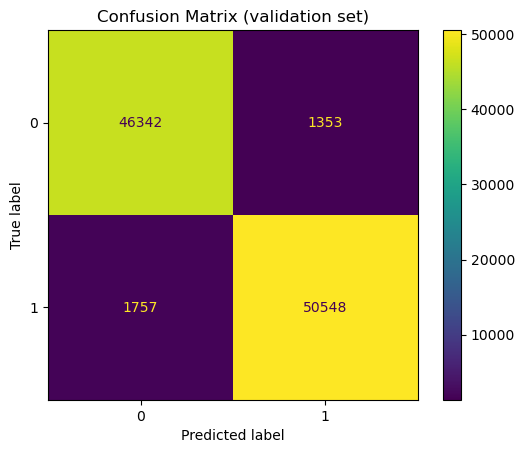

In [11]:
ConfusionMatrixDisplay.from_predictions(y_val, val_preds)
plt.title("Confusion Matrix (validation set)")
plt.show()

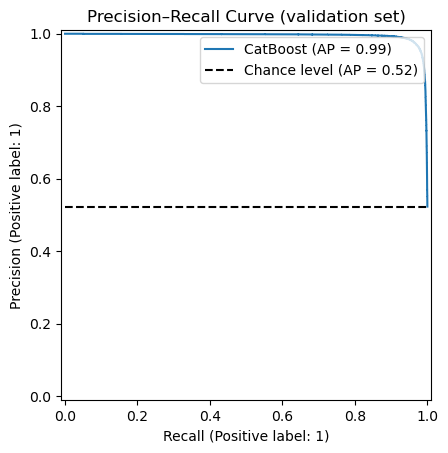

In [12]:
# Compute prediction probabilities for the positive class
val_pred_proba = clf.predict_proba(X_val)[:, 1]

# Plot PR curve
PrecisionRecallDisplay.from_predictions(
    y_val,
    val_pred_proba,
    name="CatBoost",
    plot_chance_level=True
)

plt.title("Precision–Recall Curve (validation set)")
plt.legend(loc="upper right")
plt.show()

In [13]:
# Load the test dataset and extract features using the same feature order learned during training
TEST_PATH = "task_a_test_set_sample.parquet"
test_df = pd.read_parquet(TEST_PATH)
print("Extracting test features...")
X_test = build_matrix(test_df, extractor, FEATURES)

# Ground truth labels (used only for evaluation on the sample test set)
y_test = test_df["label"].values

# Generate predicted labels for the test data
test_preds = clf.predict(X_test).squeeze()

Extracting test features...


Extracting: 100%|██████████████████████████| 1000/1000 [00:06<00:00, 155.01it/s]


In [14]:
print("\nEvaluation on the test set")

test_macro_f1 = f1_score(y_test, test_preds, average="macro")
test_macro_precision = precision_score(y_test, test_preds, average="macro")
test_macro_recall = recall_score(y_test, test_preds, average="macro")

print(f"Macro F1 score (test): {test_macro_f1:.4f}")
print(f"Macro precision (test): {test_macro_precision:.4f}")
print(f"Macro recall (test): {test_macro_recall:.4f}")

print("\nClassification report (test set):")
print(classification_report(y_test, test_preds))


Evaluation on the test set
Macro F1 score (test): 0.3849
Macro precision (test): 0.6058
Macro recall (test): 0.5905

Classification report (test set):
              precision    recall  f1-score   support

           0       0.95      0.22      0.36       777
           1       0.26      0.96      0.41       223

    accuracy                           0.39      1000
   macro avg       0.61      0.59      0.38      1000
weighted avg       0.80      0.39      0.37      1000



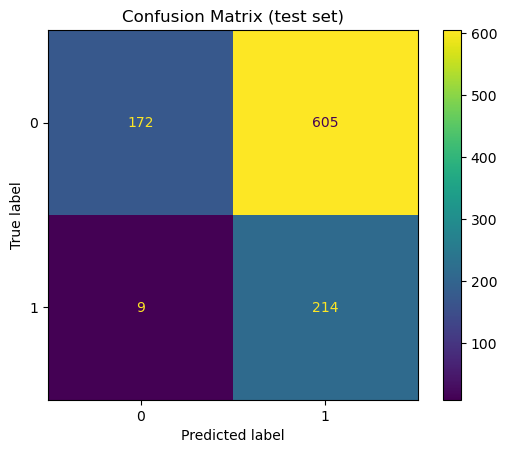

In [15]:
ConfusionMatrixDisplay.from_predictions(y_test, test_preds)
plt.title("Confusion Matrix (test set)")
plt.show()

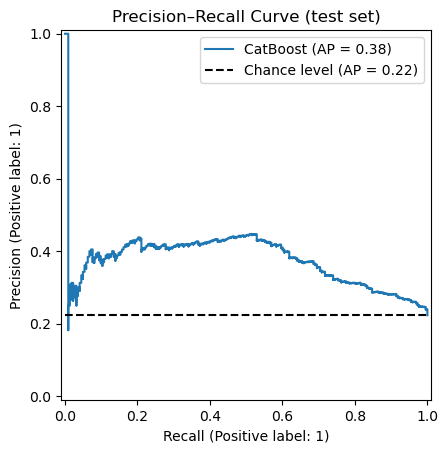

In [16]:
test_pred_proba = clf.predict_proba(X_test)[:, 1]

PrecisionRecallDisplay.from_predictions(
    y_test,
    test_pred_proba,
    name="CatBoost",
    plot_chance_level=True
)

plt.title("Precision–Recall Curve (test set)")
plt.legend(loc="upper right")
plt.show()

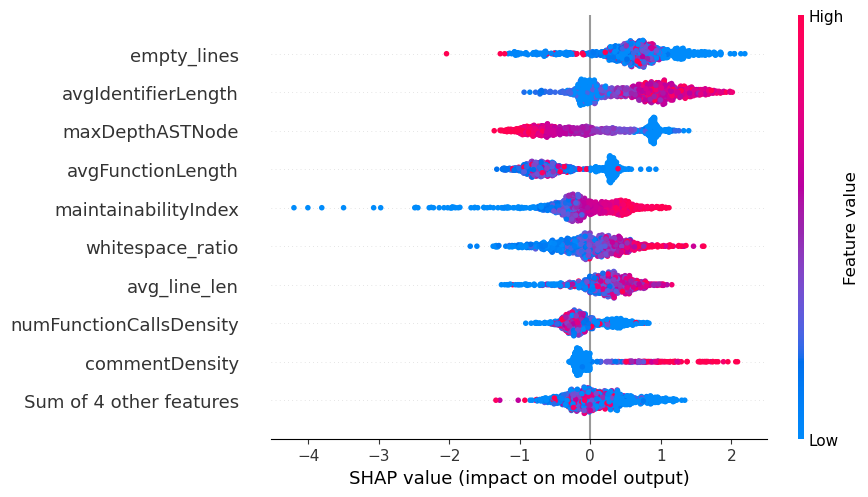

In [9]:
# This wraps the raw feature matrix together with feature names 
# so CatBoost knows which column corresponds to which feature
pool = Pool(X_test, feature_names=FEATURES)

# Compute SHAP values using CatBoost's native implementation
# Output shape: (n_samples, n_classes, n_features + 1)
shap_values = clf.get_feature_importance(pool, type="ShapValues")

values = shap_values[:, 1, :-1] # Select SHAP values for class 1
base_values = shap_values[:, 1, -1] # Extract the baseline for class 1

exp = shap.Explanation(values=values, data=X_test, feature_names=FEATURES, base_values=base_values)

# Plot a beeswarm summary
shap.plots.beeswarm(exp, show=False)
fig = plt.gcf() # Get the figure that SHAP just drew on
fig.savefig("shap_beeswarm.png", dpi=400, bbox_inches="tight")

plt.show()

In [10]:
TEST_PATH = "test.parquet"          
MODEL_PATH = "catboost_model.cbm"
FEATURES_PATH = "features.json"
SUBMISSION_PATH = "submission.csv"

with open(FEATURES_PATH, "r") as f:
    FEATURES = json.load(f)

clf = CatBoostClassifier()
clf.load_model(MODEL_PATH)

# Load test + extract features
test_df = pd.read_parquet(TEST_PATH)

extractor = FeatureExtractor()
print("Extracting test features...")
X_test = build_matrix(test_df, extractor, FEATURES)

test_preds = clf.predict(X_test).ravel()
test_labels = pd.Series(test_preds).astype(int).values

# Build submission
submission = pd.DataFrame({
    "ID": test_df["ID"].values,
    "label": test_labels
})

submission.to_csv(SUBMISSION_PATH, index=False)
print("Saved submission:", SUBMISSION_PATH)
print(submission.head())

Extracting test features...


Extracting: 100%|██████████████████████████| 1000/1000 [00:06<00:00, 162.33it/s]

Saved submission: submission.csv
     ID  label
0  2005      1
1  2384      0
2  3526      0
3  3926      0
4  7222      1


# 2. XGBoost

In [2]:
# ============================================================================
# STEP 1: INSTALL & IMPORT LIBRARIES
# ============================================================================
!pip install -q xgboost scikit-learn pandas numpy

import re
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, classification_report
from scipy.sparse import hstack
import gc

SEED = 42
np.random.seed(SEED)

print("Libraries installed and imported.")

Libraries installed and imported.


In [3]:
# ============================================================================
# STEP 2: LOAD DATA
# ============================================================================
TRAIN_PATH = "/content/drive/MyDrive/445xgboost/train.parquet"
VAL_PATH = "/content/drive/MyDrive/445xgboost/validation.parquet"

print("Loading dataset...")
train_df = pd.read_parquet(TRAIN_PATH)
val_df = pd.read_parquet(VAL_PATH)

print(f"Train shape: {train_df.shape}")
print(f"Val shape: {val_df.shape}")


Loading dataset...
Train shape: (500000, 4)
Val shape: (100000, 4)


In [4]:
# ============================================================================
# STEP 3: PREPROCESSING & FEATURE ENGINEERING
# ============================================================================

def get_handcrafted_features(text_series):
    """
    Extracts numerical stylistic features from code.
    AI code often has different structural patterns than humans.
    """
    df_feats = pd.DataFrame(index=text_series.index)

    # 1. Structural Features
    df_feats['len'] = text_series.str.len()
    df_feats['line_count'] = text_series.str.count('\n') + 1
    df_feats['avg_line_len'] = df_feats['len'] / df_feats['line_count']

    # 2. Special Character Density (Code Structure)
    specials = [';', '{', '}', '(', ')', '[', ']', '_', '#', '=']
    for char in specials:
        df_feats[f'count_{char}'] = text_series.str.count(re.escape(char))
        df_feats[f'ratio_{char}'] = df_feats[f'count_{char}'] / df_feats['len']

    # 3. Indentation patterns (AI is usually perfectly indented)
    def avg_indentation(text):
        lines = text.split('\n')
        indents = [len(line) - len(line.lstrip(' ')) for line in lines if line.strip()]
        return np.mean(indents) if indents else 0

    df_feats['avg_indent'] = text_series.apply(avg_indentation)

    return df_feats

print("Generating Handcrafted Features (Structural)...")
train_feats = get_handcrafted_features(train_df['code'])
val_feats = get_handcrafted_features(val_df['code'])
print("Structural features created.")


Generating Handcrafted Features (Structural)...
Structural features created.


In [6]:

# ============================================================================
# STEP 4: TF-IDF VECTORIZATION (The "Bag of Words" approach)

# ============================================================================

# We limit features to top 5000 to save memory and reduce noise
tfidf = TfidfVectorizer(
    max_features=5000,
    analyzer='word',
    token_pattern=r'\w+', # Simple tokenizer
    ngram_range=(1, 2),   # Use unigrams (word) and bigrams (word-word)
    dtype=np.float32      # Use float32 to save RAM
)

print("Fitting TF-IDF (This learns the vocabulary)...")
# We fit only on training data to avoid data leakage
tfidf.fit(train_df['code'])

print("Transforming Text to Vectors...")
X_train_tfidf = tfidf.transform(train_df['code'])
X_val_tfidf = tfidf.transform(val_df['code'])


Fitting TF-IDF (This learns the vocabulary)...
Transforming Text to Vectors...


In [7]:

# ============================================================================
# MODIFIED STEP 5: COMBINE FEATURES & SAVE SCALERS
# ============================================================================
print("Stacking features...")

# Dictionary to store scaling stats for the Test set
scaling_stats = {}

# Scale dense features using Train statistics
for col in train_feats.columns:
    m = train_feats[col].mean()
    s = train_feats[col].std() + 1e-6

    # Store for later
    scaling_stats[col] = {'mean': m, 'std': s}

    # Apply to Train and Val
    train_feats[col] = (train_feats[col] - m) / s
    val_feats[col] = (val_feats[col] - m) / s

# Stack Sparse (TF-IDF) and Dense (Handcrafted)
X_train = hstack([X_train_tfidf, train_feats])
X_val = hstack([X_val_tfidf, val_feats])

y_train = train_df['label']
y_val = val_df['label']

print(f"Final Training Data Shape: {X_train.shape}")

# Cleanup
del train_df, val_df, X_train_tfidf, X_val_tfidf, train_feats, val_feats
gc.collect()


Stacking features...
Final Training Data Shape: (500000, 5024)


17

In [8]:

# ============================================================================
# STEP 6: MODEL TRAINING (XGBoost)
# ============================================================================

print("Initializing XGBoost...")

# Hyperparameters optimized for large sparse datasets
clf = xgb.XGBClassifier(
    n_estimators=2000,        # High number of trees
    learning_rate=0.05,       # Slower learning for better accuracy
    max_depth=8,              # Deeper trees for complex interactions
    subsample=0.8,            # Data augmentation: Use 80% of data per tree
    colsample_bytree=0.8,     # Feature augmentation: Use 80% of features per tree
    objective='binary:logistic',
    tree_method='hist',       # Required for GPU usage
    device='cuda',            # Use the A100
    random_state=SEED,
    n_jobs=-1,
    early_stopping_rounds=50  # Stop if validation score doesn't improve
)

print("Starting Training...")
clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100  # Print progress every 100 trees
)


Initializing XGBoost...
Starting Training...
[0]	validation_0-logloss:0.66580
[100]	validation_0-logloss:0.08239
[200]	validation_0-logloss:0.07178
[300]	validation_0-logloss:0.06719
[400]	validation_0-logloss:0.06414
[500]	validation_0-logloss:0.06217
[600]	validation_0-logloss:0.06048
[700]	validation_0-logloss:0.05913
[800]	validation_0-logloss:0.05817
[900]	validation_0-logloss:0.05739
[1000]	validation_0-logloss:0.05668
[1100]	validation_0-logloss:0.05600
[1200]	validation_0-logloss:0.05542
[1300]	validation_0-logloss:0.05485
[1400]	validation_0-logloss:0.05431
[1500]	validation_0-logloss:0.05400
[1600]	validation_0-logloss:0.05368
[1700]	validation_0-logloss:0.05337
[1800]	validation_0-logloss:0.05303
[1900]	validation_0-logloss:0.05272
[1999]	validation_0-logloss:0.05245


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='cuda', early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=2000,
              n_jobs=-1, num_parallel_tree=None, ...)

## 2.1 XGBoost Results

In [9]:

# ============================================================================
# STEP 7: EVALUATION
# ============================================================================

print("\nRunning Evaluation...")
preds = clf.predict(X_val)
probs = clf.predict_proba(X_val)[:, 1]

f1 = f1_score(y_val, preds, average='macro')
acc = accuracy_score(y_val, preds)

print("="*30)
print(f"FINAL MACRO F1: {f1:.4f}")
print(f"FINAL ACCURACY: {acc:.4f}")
print("="*30)

print("\nClassification Report:")
print(classification_report(y_val, preds, target_names=['Human', 'AI']))

# Save the model
clf.save_model("xgboost_code_classifier.json")
print("Model saved to xgboost_code_classifier.json")


Running Evaluation...
FINAL MACRO F1: 0.9831
FINAL ACCURACY: 0.9831

Classification Report:
              precision    recall  f1-score   support

       Human       0.97      0.99      0.98     47695
          AI       0.99      0.98      0.98     52305

    accuracy                           0.98    100000
   macro avg       0.98      0.98      0.98    100000
weighted avg       0.98      0.98      0.98    100000

Model saved to xgboost_code_classifier.json


In [10]:
# ============================================================================
# STEP 8: GENERATE SUBMISSION
# ============================================================================
TEST_PATH = "/content/drive/MyDrive/445xgboost/test.parquet"

print("1. Loading Test Data...")
test_df = pd.read_parquet(TEST_PATH)
print(f"   Test shape: {test_df.shape}")

# ---------------------------------------------------------
# A. Feature Engineering (Must match Step 3)
# ---------------------------------------------------------
print("2. Generating Handcrafted Features for Test...")
test_feats = get_handcrafted_features(test_df['code'])

# ---------------------------------------------------------
# B. Scaling (Must match Step 5)
# ---------------------------------------------------------
print("3. Scaling Test Features using Train Stats...")
# We use the 'scaling_stats' dictionary created in Step 5
for col in test_feats.columns:
    if col in scaling_stats:
        m = scaling_stats[col]['mean']
        s = scaling_stats[col]['std']
        test_feats[col] = (test_feats[col] - m) / s
    else:
        # Fallback if a new column somehow appears (unlikely)
        test_feats[col] = 0

# ---------------------------------------------------------
# C. Vectorization (Must match Step 4)
# ---------------------------------------------------------
print("4. Vectorizing Test Data...")
# CRITICAL: Use .transform(), NOT .fit_transform()
X_test_tfidf = tfidf.transform(test_df['code'])

# ---------------------------------------------------------
# D. Stacking
# ---------------------------------------------------------
print("5. Stacking...")
X_test = hstack([X_test_tfidf, test_feats])
print(f"   Final Test Shape: {X_test.shape}")

# ---------------------------------------------------------
# E. Prediction
# ---------------------------------------------------------
print("6. Predicting...")
# Predict Class Labels (0 or 1)
test_preds = clf.predict(X_test)

# Optional: Get probabilities if you want to inspect confidence
# test_probs = clf.predict_proba(X_test)[:, 1]

# ---------------------------------------------------------
# F. Save to CSV
# ---------------------------------------------------------
print("7. Saving Submission...")

# Check if 'id' or 'ID' exists, otherwise use index
id_col = 'ID' if 'ID' in test_df.columns else 'id'
if id_col not in test_df.columns:
    print("   Warning: ID column not found. Using index.")
    ids = test_df.index
else:
    ids = test_df[id_col]

submission = pd.DataFrame({
    id_col: ids,
    'label': test_preds
})

submission.to_csv("submission.csv", index=False)
print("✓ Saved to 'submission.csv'")
print(submission.head())

1. Loading Test Data...
   Test shape: (1000, 2)
2. Generating Handcrafted Features for Test...
3. Scaling Test Features using Train Stats...
4. Vectorizing Test Data...
5. Stacking...
   Final Test Shape: (1000, 5024)
6. Predicting...
7. Saving Submission...
✓ Saved to 'submission.csv'
        ID  label
2005  2005      1
2384  2384      0
3526  3526      0
3926  3926      0
7222  7222      1


Generating Confusion Matrix...


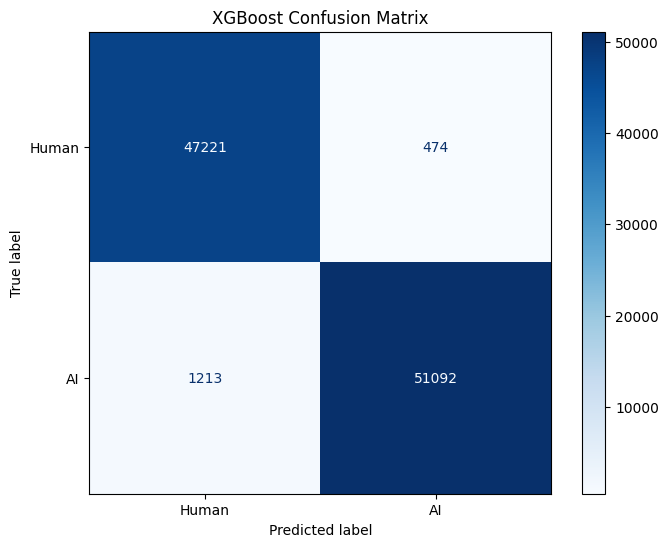

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ============================================================================
# VISUALIZE CONFUSION MATRIX
# ============================================================================
print("Generating Confusion Matrix...")

# 1. Calculate the matrix
cm = confusion_matrix(y_val, preds)

# 2. Create the display object
# Assuming 0 = Human and 1 = AI (adjust based on your actual labels)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Human', 'AI']
)

# 3. Plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax, values_format='d') # 'd' formats numbers as integers
plt.title('XGBoost Confusion Matrix')
plt.show()

# 3. TF-IDF + Naive Bayes

In [1]:
# %%
# Install the libraries needed for building and evaluating a simple TF-IDF and Naive Bayes baseline.
!pip install -q scikit-learn datasets pyarrow pandas numpy

In [2]:
# %%
import os
import numpy as np
import pandas as pd
import logging
import joblib  # Used to save the scikit-learn model later

# Data Loading
from datasets import load_dataset, Dataset

# Scikit-Learn Imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Initialize logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Combining them helps detect style.
NGRAM_RANGE = (1, 2)

# Limit vocabulary to top N frequent words to keep memory usage safe
MAX_FEATURES = 100000

OUTPUT_DIR = "/content"
SUBMISSION_FILE = "submission.csv"

print("Configuration set for TF-IDF + Naive Bayes")

Configuration set for TF-IDF + Naive Bayes


In [3]:
# %%
# Data Preparation

def prepare_data():
    logger.info("Loading Data from Local Files...")

    # Load Training Data
    train_ds = load_dataset("parquet", data_files="./train.parquet", split="train")

    # Load Validation Data
    val_ds = load_dataset("parquet", data_files="./validation.parquet", split="train")

    logger.info(f"Train size: {len(train_ds)}, Val size: {len(val_ds)}")

    # Print column names to verify dataset structure
    print("Dataset Columns:", train_ds.column_names)

    return train_ds, val_ds

# Execute the data preparation
train_ds, val_ds = prepare_data()

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset Columns: ['code', 'generator', 'label', 'language']


## 3.1 TF-IDF + Naive Bayes Results

In [4]:
# %%
# Training TF-IDF + Naive Bayes

# Convert Hugging Face datasets into lists for scikit-learn
logger.info("Converting datasets to lists for Scikit-Learn...")

# Extract training data
X_train = train_ds['code']
y_train = train_ds['label']

# Extract validation data
X_val = val_ds['code']
y_val = val_ds['label']

# Replace missing code entries with empty strings to avoid TF-IDF errors
X_train = [x if x is not None else "" for x in X_train]
X_val = [x if x is not None else "" for x in X_val]

logger.info(f"Training Data Size: {len(X_train)}")

# Build a pipeline that combines TF-IDF vectorization with Naive Bayes classification
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_features=100_000)),
    ('clf', MultinomialNB(alpha=0.1)) # Apply smoothing to handle rare or unseen words
])

# Train the model on the training data
logger.info("Fitting the TF-IDF + Naive Bayes pipeline...")
pipeline.fit(X_train, y_train)
logger.info("Training complete.")

# Generate predictions on the validation set
logger.info("Evaluating on validation set...")
y_pred = pipeline.predict(X_val)

# Calculate Metrics
val_accuracy = accuracy_score(y_val, y_pred)
print(f"\n Validation Accuracy: {val_accuracy:.4f}")

# Print detailed precision, recall, and F1 scores
# Assuming 0 = Human, 1 = AI (Standard for these datasets)
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=["Human (0)", "AI (1)"]))


 Validation Accuracy: 0.8285

Classification Report:
              precision    recall  f1-score   support

   Human (0)       0.77      0.91      0.83     47695
      AI (1)       0.90      0.75      0.82     52305

    accuracy                           0.83    100000
   macro avg       0.84      0.83      0.83    100000
weighted avg       0.84      0.83      0.83    100000



In [5]:
# %%
# Save the trained model
import joblib

model_filename = os.path.join(OUTPUT_DIR, "tfidf_nb_model.pkl")

# Create the output directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Save the pipeline
joblib.dump(pipeline, model_filename)
logger.info(f"Model saved to {model_filename}")

In [7]:
# %%
# Train a faster TF-IDF model using word trigrams and a linear SVM
from sklearn.linear_model import SGDClassifier
from datasets import load_dataset

logger.info("Training Fast Model (Word Trigrams + SVM)...")

# Define a lightweight pipeline for fast training and inference
pipeline_fast = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=5, max_features=150_000)),
    ('clf', SGDClassifier(loss='hinge', alpha=1e-4, random_state=42, max_iter=1000, tol=1e-3))
])

# Train the fast model on the training data
pipeline_fast.fit(X_train, y_train)
logger.info("Training complete.")

# Evaluate the model on the validation set
y_pred = pipeline_fast.predict(X_val)
print(f"\n Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")

# Load the test dataset for submission
logger.info("Loading Test Data...")
test_ds = load_dataset("parquet", data_files="./test.parquet", split="train")

# Replace missing code entries before prediction
X_test_clean = [x if x is not None else "" for x in test_ds['code']]
preds = pipeline_fast.predict(X_test_clean)

# Save
submission = pd.DataFrame({"ID": test_ds['ID'], "label": preds})
submission.to_csv("./submission.csv", index=False)
print("Saved to submission.csv")


 Validation Accuracy: 0.8492


Generating train split: 0 examples [00:00, ? examples/s]

Saved to submission.csv


# 4. ModernBERT

In [1]:
# Install required libraries for Transformers, Datasets, Evaluation, and Hardware Acceleration
!pip install -q "transformers>=4.48.0" datasets evaluate accelerate pyarrow scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.6 MB/s eta 0:00:00


In [2]:
# Import standard libraries for file system operations and data manipulation
import os
import torch
import numpy as np
import pandas as pd

# Import Hugging Face libraries for dataset handling and transformer models
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorWithPadding
)

# Import metrics for performance evaluation
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import logging

# Initialize logging to monitor training progress
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Assign the computing device (use GPU if available, otherwise fallback to CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Configuration for model architecture and training hyperparameters
MODEL_NAME = "answerdotai/ModernBERT-base"
MAX_LENGTH = 512  # Maximum token sequence length
BATCH_SIZE = 128  # Number of samples per training step
EPOCHS = 3        # Total number of training passes
LEARNING_RATE = 2e-5

# Directory for saving model checkpoints and the final submission file name
OUTPUT_DIR = "./modernbert-task-a"
SUBMISSION_FILE = "submission.csv"

In [3]:
def prepare_data():
    logger.info("Loading Training Data from HuggingFace...")
    # Load the official dataset from HuggingFace using the 'A' configuration
    dataset = load_dataset("DaniilOr/SemEval-2026-Task13", "A")

    # Separate the dataset into training and validation splits
    train_ds = dataset['train']
    val_ds = dataset['validation']

    # Log the number of examples in each split for verification
    logger.info(f"Train size: {len(train_ds)}, Val size: {len(val_ds)}")
    return train_ds, val_ds

# Execute the data preparation and store the resulting datasets
train_ds, val_ds = prepare_data()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/801 [00:00<?, ?B/s]

task_a/task_a_training_set_1.parquet:   0%|          | 0.00/203M [00:00<?, ?B/s]

task_a/task_a_validation_set.parquet:   0%|          | 0.00/40.5M [00:00<?, ?B/s]

task_a/task_a_test_set_sample.parquet:   0%|          | 0.00/593k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/500000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [4]:
# Initialize the tokenizer corresponding to the pre-trained ModernBERT model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    # Convert code snippets into input IDs and attention masks
    # Truncation is enabled to handle sequences longer than MAX_LENGTH
    return tokenizer(
        examples['code'],
        truncation=True,
        padding=False, # Padding is handled dynamically by the DataCollator
        max_length=MAX_LENGTH
    )

logger.info("Tokenizing datasets...")
# Process the entire training and validation datasets in batches
# Existing text columns are removed to save memory and keep only tensors
train_tokenized = train_ds.map(tokenize_function, batched=True, remove_columns=train_ds.column_names)
val_tokenized = val_ds.map(tokenize_function, batched=True, remove_columns=val_ds.column_names)

# Add the target labels back to the processed datasets
# The Trainer API specifically looks for a column named 'labels'
train_tokenized = train_tokenized.add_column("labels", train_ds["label"])
val_tokenized = val_tokenized.add_column("labels", val_ds["label"])

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Map:   0%|          | 0/500000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [5]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert raw model outputs (logits) into class indices (0 or 1)
    predictions = np.argmax(logits, axis=-1)

    # Calculate Precision, Recall, and F1-score using 'macro' averaging as required by SemEval
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')

    # Calculate the overall accuracy of the predictions
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Load the ModernBERT model with a classification head for two classes
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    problem_type="single_label_classification"
).to(device) # Move the model to the specified device (GPU or CPU)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Define training hyperparameters and environment settings
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR, # Path to save model checkpoints
    num_train_epochs=EPOCHS, # Number of complete passes through the dataset
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=1,
    learning_rate=LEARNING_RATE,
    weight_decay=0.01, # Regularization to prevent overfitting
    eval_strategy="steps", # Evaluate the model every 'eval_steps'
    eval_steps=1000,
    save_strategy="steps", # Save the model every 'save_steps'
    save_steps=1000,
    load_best_model_at_end=True, # Revert to the best performing version after training
    metric_for_best_model="f1", # Use Macro F1 score to determine the best model
    greater_is_better=True,
    save_total_limit=1, # Keep only the single best checkpoint to save space
    optim="adamw_torch_fused",
    bf16=True,
    tf32=True, # Enable TensorFloat32 for A100 GPU optimization
    dataloader_num_workers=4, # Use multiple CPU cores for data loading
    report_to="none" # Disable logging to external platforms like WandB
)

# Initialize the Trainer API with all components
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
    # Dynamically pads sequences in a batch to the length of the longest sequence
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    # Stop training if validation performance stops improving
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Execute the training process
trainer.train()

# Save the best model and tokenizer to the output directory
trainer.save_model(OUTPUT_DIR)

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)
/tmp/ipython-input-2053535238.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with 

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1000,0.026400,0.017723,0.993690,0.993678,0.993562,0.993811
2000,0.018100,0.015565,0.994670,0.994658,0.994721,0.994598
3000,0.016600,0.013435,0.995240,0.995230,0.995195,0.995267
4000,0.013500,0.012145,0.995670,0.995661,0.995679,0.995643
5000,0.009900,0.011466,0.995700,0.995691,0.995686,0.995695
6000,0.009700,0.012316,0.995850,0.995841,0.995916,0.995770
7000,0.008400,0.010421,0.996250,0.996243,0.996173,0.996317
8000,0.006000,0.010673,0.996600,0.996593,0.996545,0.996644
9000,0.003700,0.011823,0.996540,0.996533,0.996479,0.996590
10000,0.003100,0.011420,0.996900,0.996893,0.996931,0.996856


## 4.1 ModernBERT Results


--- FINAL VALIDATION METRICS ---
Macro F1-Score: 0.9970
Macro Precision: 0.9970
Macro Recall:    0.9970


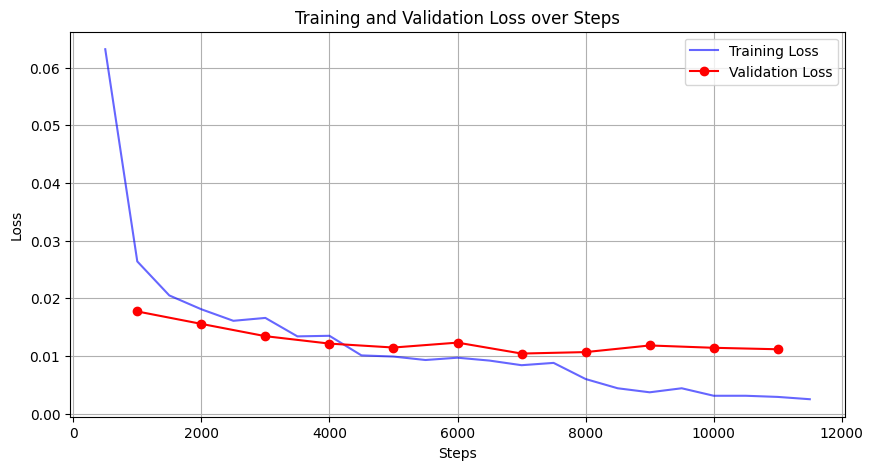

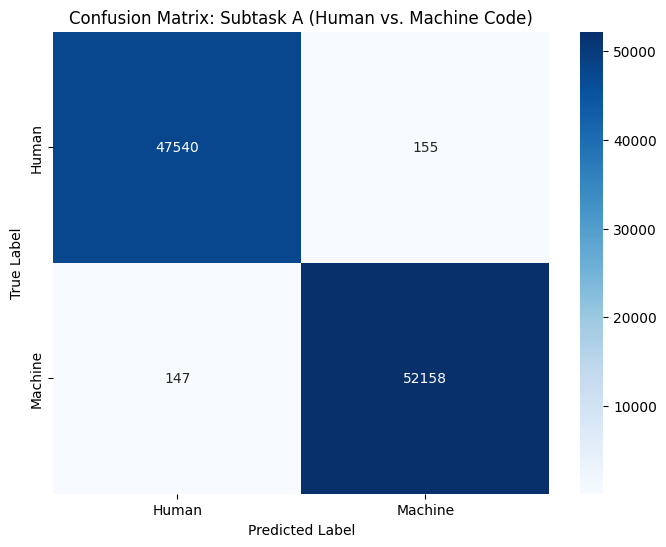

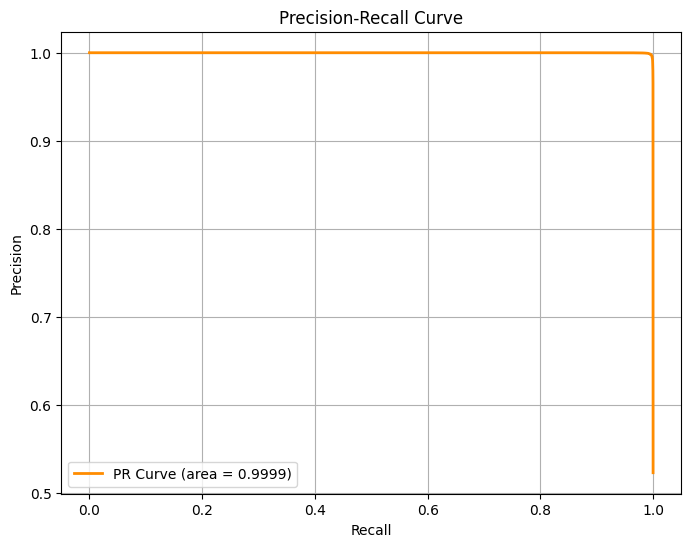

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, classification_report
import numpy as np

# 1. Extract Training Logs for Progress Plots
history = trainer.state.log_history
steps = [x['step'] for x in history if 'loss' in x]
train_loss = [x['loss'] for x in history if 'loss' in x]
val_steps = [x['step'] for x in history if 'eval_loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
f1_scores = [x['eval_f1'] for x in history if 'eval_f1' in x]

# Plot 1: Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(steps, train_loss, label='Training Loss', color='blue', alpha=0.6)
plt.plot(val_steps, val_loss, label='Validation Loss', color='red', marker='o')
plt.title('Training and Validation Loss over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png')

# 2. Generate Validation Predictions for Matrix & PR Curve
logger.info("Generating predictions on validation set for visualizations...")
output = trainer.predict(val_tokenized)
preds = np.argmax(output.predictions, axis=-1)
probs = torch.nn.functional.softmax(torch.tensor(output.predictions), dim=-1)[:, 1].numpy()
labels = output.label_ids

# Plot 2: Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Machine'], yticklabels=['Human', 'Machine'])
plt.title('Confusion Matrix: Subtask A (Human vs. Machine Code)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png')

# Plot 3: Precision-Recall Curve
precision_pts, recall_pts, _ = precision_recall_curve(labels, probs)
pr_auc = auc(recall_pts, precision_pts)
plt.figure(figsize=(8, 6))
plt.plot(recall_pts, precision_pts, color='darkorange', lw=2, label=f'PR Curve (area = {pr_auc:.4f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.grid(True)
plt.savefig('pr_curve.png')

# Print Final Summary Table
report = classification_report(labels, preds, target_names=['Human', 'Machine'], output_dict=True)
print(f"\n--- FINAL VALIDATION METRICS ---")
print(f"Macro F1-Score: {report['macro avg']['f1-score']:.4f}")
print(f"Macro Precision: {report['macro avg']['precision']:.4f}")
print(f"Macro Recall:    {report['macro avg']['recall']:.4f}")

In [8]:
import pandas as pd
import torch

@torch.no_grad()
def generate_submission(
    test_parquet_path: str,
    output_csv_path: str,
    infer_batch_size: int = 32
):
    model.eval()

    # Load test set
    test_df = pd.read_parquet(test_parquet_path)

    # Robust ID handling (id or ID, fallback to index)
    if "id" in test_df.columns:
        id_col = "id"
    elif "ID" in test_df.columns:
        id_col = "ID"
    else:
        test_df["id"] = test_df.index
        id_col = "id"

    results = []

    # Batched inference
    for start in range(0, len(test_df), infer_batch_size):
        batch = test_df.iloc[start : start + infer_batch_size]

        codes = batch["code"].tolist()
        ids = batch[id_col].tolist()

        inputs = tokenizer(
            codes,
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors="pt"
        ).to(device)

        logits = model(**inputs).logits
        preds = torch.argmax(logits, dim=-1).cpu().numpy()

        for sample_id, pred in zip(ids, preds):
            results.append({
                "id": sample_id,
                "label": int(pred)
            })

    # Create submission file
    submission_df = pd.DataFrame(results)
    submission_df.to_csv(output_csv_path, index=False)

    print(f"submission.csv created successfully at: {output_csv_path}")
    print("Columns:", submission_df.columns.tolist())
    print("Number of rows:", len(submission_df))


# -------- RUN --------

generate_submission(
    test_parquet_path="task_a_test_set_sample.parquet",
    output_csv_path="submission.csv",
    infer_batch_size=32
)


submission.csv created successfully at: submission.csv
Columns: ['id', 'label']
Number of rows: 1000


# 5. UniXcoder

In [1]:
# INSTALL REQUIRED PACKAGES

!pip install -q transformers datasets scikit-learn accelerate

print("All packages installed")

All packages installed


In [2]:
# IMPORT ALL LIBRARIES


import os
import re
import time
import warnings
from datetime import datetime
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    set_seed,
)

from datasets import Dataset, DatasetDict, load_dataset, load_from_disk

from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score,
    confusion_matrix, classification_report,
    precision_recall_curve, roc_curve, auc,
)

# Suppress warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
SEED = 42
set_seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(" All libraries imported")
print(f" PyTorch: {torch.__version__}")
print(f" CUDA: {torch.cuda.is_available()}")

 All libraries imported
 PyTorch: 2.9.0+cu126
 CUDA: True


In [3]:
# CONFIGURATION


class Config:
    # Model
    MODEL_NAME = "microsoft/codebert-base"
    NUM_LABELS = 2
    MAX_LENGTH = 512


    BATCH_SIZE = 32
    GRADIENT_ACCUMULATION_STEPS = 4    # Effective batch = 128
    LEARNING_RATE = 2e-5
    WEIGHT_DECAY = 0.01
    NUM_EPOCHS = 3
    WARMUP_RATIO = 0.1

    # Evaluation & Saving
    EVAL_STEPS = 1000
    SAVE_STEPS = 1000
    LOGGING_STEPS = 50
    SAVE_TOTAL_LIMIT = 2
    EARLY_STOPPING_PATIENCE = 3

    # Paths
    OUTPUT_DIR = "./codebert_varmasking"
    CACHE_DIR = "./cache"
    EXPERIMENT_NAME = "Variable_masked"

# Print configuration

print(f"Model: {Config.MODEL_NAME}")
print(f"Batch Size: {Config.BATCH_SIZE}")
print(f"Gradient Accumulation: {Config.GRADIENT_ACCUMULATION_STEPS}")
print(f"Effective Batch: {Config.BATCH_SIZE * Config.GRADIENT_ACCUMULATION_STEPS}")
print(f"Learning Rate: {Config.LEARNING_RATE} ")
print(f"Weight Decay: {Config.WEIGHT_DECAY}")
print(f"Epochs: {Config.NUM_EPOCHS}")


Model: microsoft/codebert-base
Batch Size: 32
Gradient Accumulation: 4
Effective Batch: 128
Learning Rate: 2e-05 
Weight Decay: 0.01
Epochs: 3


In [4]:
# Mount google drive for loading dataset (i.e. train.parquet and validation.parquet)

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [5]:
TRAIN_PATH = "/content/drive/MyDrive/train.parquet"
VAL_PATH = "/content/drive/MyDrive/validation.parquet"

# Load data
print("Loading dataset")
train_df = pd.read_parquet(TRAIN_PATH)
val_df = pd.read_parquet(VAL_PATH)

print(f" Training samples: {len(train_df):,}")
print(f" Validation samples: {len(val_df):,}")

# Convert to HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))

dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

print(" Dataset loaded successfully")

Loading dataset
 Training samples: 500,000
 Validation samples: 100,000
 Dataset loaded successfully


In [6]:
# DATASET EXPLORATION


print("Dataset Exploration")

# Check columns
print(f"\nColumns: {dataset['train'].column_names}")

# Sample
print(f"\nSample code (truncated):")
print(dataset['train'][0]['code'][:300] + "...")

# Class distribution
train_labels = dataset['train']['label']
print(f"\nClass Distribution:")
for label, count in Counter(train_labels).items():
    name = "Human" if label == 0 else "AI"
    print(f"  {name}: {count:,} ({count/len(train_labels)*100:.1f}%)")

# Language distribution
if 'language' in dataset['train'].column_names:
    print(f"\nLanguage Distribution:")
    for lang, count in Counter(dataset['train']['language']).most_common():
        print(f"  {lang}: {count:,} ({count/len(train_labels)*100:.1f}%)")



Dataset Exploration

Columns: ['code', 'generator', 'label', 'language']

Sample code (truncated):
(a, b, c, d) = [int(x) for x in input().split()]
k = input()
(p, q, r, s) = (0, 0, 0, 0)
for i in k:
	if i == '1':
		p += 1
	elif i == '2':
		q += 1
	elif i == '3':
		r += 1
	elif i == '4':
		s += 1
print(a * p + b * q + c * r + d * s)
...

Class Distribution:
  Human: 238,475 (47.7%)
  AI: 261,525 (52.3%)

Language Distribution:
  Python: 457,306 (91.5%)
  C++: 23,392 (4.7%)
  Java: 19,302 (3.9%)


In [30]:
#  PREPROCESSING: VARIABLE MASKING FOR CROSS-LANGUAGE GENERALIZATION


import re

def preprocess(code: str, language: str = None) -> str:
    """
    preprocessing with variable masking for cross-language generalization.

    Key differences from GPTSniffer C8:
    1. Masks variable names → _V_ (forces structural learning)
    2. Masks string literals → _S_ (removes domain-specific content)
    3. Masks numbers → _N_ (specific values don't generalize)
    4. Keeps keywords and structure intact
    """

    # 1. Remove comments (all languages)
    # Python
    code = re.sub(r'#.*$', '', code, flags=re.MULTILINE)
    code = re.sub(r'"""[\s\S]*?"""', '', code)
    code = re.sub(r"'''[\s\S]*?'''", '', code)
    # C-style (covers Java, C++, C#, Go, JS, PHP)
    code = re.sub(r'//.*$', '', code, flags=re.MULTILINE)
    code = re.sub(r'/\*[\s\S]*?\*/', '', code)

    # 2. Remove imports (language-specific syntax)
    code = re.sub(r'^import\s+.*$', '', code, flags=re.MULTILINE)
    code = re.sub(r'^from\s+\S+\s+import\s+.*$', '', code, flags=re.MULTILINE)
    code = re.sub(r'^#include\s*[<"].*?[>"].*$', '', code, flags=re.MULTILINE)
    code = re.sub(r'^using\s+.*?;', '', code, flags=re.MULTILINE)
    code = re.sub(r'^package\s+.*?;', '', code, flags=re.MULTILINE)
    code = re.sub(r'^require\s*[\(]?.*$', '', code, flags=re.MULTILINE)
    code = re.sub(r'^use\s+.*?;', '', code, flags=re.MULTILINE)

    # 3.Normalize literals
    # Strings → placeholder (since the test content is domain-specific)
    code = re.sub(r'"(?:[^"\\]|\\.)*"', '"_S_"', code)
    code = re.sub(r"'(?:[^'\\]|\\.)*'", "'_S_'", code)
    code = re.sub(r'`(?:[^`\\]|\\.)*`', '`_S_`', code)

    # Numbers → placeholder (specific values don't generalize)
    code = re.sub(r'\b\d+\.?\d*[fFdDlL]?\b', '_N_', code)

    # 4. Mask variable names
    keywords = {
        # Python
        'def', 'class', 'if', 'else', 'elif', 'for', 'while', 'return',
        'import', 'from', 'as', 'try', 'except', 'finally', 'with',
        'lambda', 'yield', 'assert', 'pass', 'break', 'continue',
        'and', 'or', 'not', 'in', 'is', 'None', 'True', 'False',
        'global', 'nonlocal', 'raise', 'del', 'async', 'await',
        # C/C++/Java/C#
        'int', 'float', 'double', 'char', 'void', 'bool', 'boolean',
        'long', 'short', 'unsigned', 'signed', 'const', 'static',
        'public', 'private', 'protected', 'class', 'struct', 'enum',
        'new', 'delete', 'this', 'super', 'null', 'nullptr',
        'switch', 'case', 'default', 'do', 'goto',
        'catch', 'throw', 'throws',
        'virtual', 'override', 'abstract', 'interface', 'extends',
        'implements', 'final', 'volatile', 'synchronized',
        'sizeof', 'typeof', 'instanceof', 'namespace',
        'extern', 'register', 'auto', 'inline', 'template',
        'true', 'false', 'string', 'String', 'var', 'let',
        # Go
        'func', 'package', 'type', 'map', 'chan', 'go', 'select',
        'defer', 'range', 'make', 'append',
        # PHP
        'function', 'echo', 'print', 'array', 'foreach', 'endif',
        'endfor', 'endwhile', 'endforeach',
        # JavaScript
        'undefined', 'NaN', 'Infinity', 'constructor', 'prototype',
        # Common built-ins
        'print', 'len', 'range', 'str', 'list', 'dict', 'set',
        'input', 'open', 'file', 'main', 'args', 'argv', 'self', 'cls',
        'printf', 'scanf', 'cout', 'cin', 'endl', 'std',
        'System', 'out', 'println', 'Math', 'Arrays', 'ArrayList',
        # Placeholders
        '_S_', '_N_', '_V_',
    }

    def replace_identifier(match):
        name = match.group(1)
        if name in keywords:
            return name
        return '_V_'

    code = re.sub(r'\b([a-zA-Z_][a-zA-Z0-9_]*)\b', replace_identifier, code)

    # 5. Clean up whitespace
    lines = [line for line in code.split('\n') if line.strip()]
    code = '\n'.join(lines)

    return code.strip()


#  TEST THE  PREPROCESSING
sample_code = """
import numpy as np
from collections import defaultdict

# Calculate the average score
def calculate_average(scores):
    '''Return the mean of scores.'''
    total_sum = 0
    item_count = 0
    for score in scores:
        if score >= 0:
            total_sum += score
            item_count += 1
    return total_sum / item_count if item_count > 0 else 0
"""

print("BEFORE:")
print(sample_code)
print("AFTER PREPROCESSING:")
print(preprocess(sample_code, 'python'))

BEFORE:

import numpy as np
from collections import defaultdict

# Calculate the average score
def calculate_average(scores):
    '''Return the mean of scores.'''
    total_sum = 0
    item_count = 0
    for score in scores:
        if score >= 0:
            total_sum += score
            item_count += 1
    return total_sum / item_count if item_count > 0 else 0

AFTER PREPROCESSING:
def _V_(_V_):
    _V_ = _N_
    _V_ = _N_
    for _V_ in _V_:
        if _V_ >= _N_:
            _V_ += _V_
            _V_ += _N_
    return _V_ / _V_ if _V_ > _N_ else _N_


In [8]:
# APPLY PREPROCESSING TO DATASET

def apply_preprocessing(example):
    """Apply preprocessing with variable masking."""
    processed_code = preprocess(example['code'], example['language'])
    return {'code': processed_code}

print("Applying variable masking")

# Apply to dataset
dataset_novel = dataset.map(
    apply_preprocessing,
    num_proc=4,
    desc="Applying Preprocessing"
)

print("preprocessing complete")

# Check a sample
print("\nSample BEFORE:")
print(dataset['train'][0]['code'][:400])
print("\n" )
print("Sample AFTER PREPROCESSING:")
print("\n")
print(dataset_novel['train'][0]['code'][:400])

Applying variable masking


Applying Preprocessing (num_proc=4):   0%|          | 0/500000 [00:00<?, ? examples/s]

Applying Preprocessing (num_proc=4):   0%|          | 0/100000 [00:00<?, ? examples/s]

preprocessing complete

Sample BEFORE:
(a, b, c, d) = [int(x) for x in input().split()]
k = input()
(p, q, r, s) = (0, 0, 0, 0)
for i in k:
	if i == '1':
		p += 1
	elif i == '2':
		q += 1
	elif i == '3':
		r += 1
	elif i == '4':
		s += 1
print(a * p + b * q + c * r + d * s)



Sample AFTER PREPROCESSING:


(_V_, _V_, _V_, _V_) = [int(_V_) for _V_ in input()._V_()]
_V_ = input()
(_V_, _V_, _V_, _V_) = (_N_, _N_, _N_, _N_)
for _V_ in _V_:
	if _V_ == '_S_':
		_V_ += _N_
	elif _V_ == '_S_':
		_V_ += _N_
	elif _V_ == '_S_':
		_V_ += _N_
	elif _V_ == '_S_':
		_V_ += _N_
print(_V_ * _V_ + _V_ * _V_ + _V_ * _V_ + _V_ * _V_)


In [9]:
# INITIALIZE TOKENIZER

print("Loading tokenizer")

tokenizer = AutoTokenizer.from_pretrained(
    Config.MODEL_NAME,
    cache_dir=Config.CACHE_DIR
)

print(f" Tokenizer loaded: {Config.MODEL_NAME}")
print(f"  Vocabulary size: {tokenizer.vocab_size:,}")
def tokenize_function(examples):
    """
    Tokenize code samples for CodeBERT.

    - truncation=True: Cut sequences > 512 tokens
    - padding='max_length': Pad shorter sequences to 512
    """
    return tokenizer(
        examples['code'],
        truncation=True,
        padding='max_length',
        max_length=Config.MAX_LENGTH,
        return_tensors=None,
    )



Loading tokenizer


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

 Tokenizer loaded: microsoft/codebert-base
  Vocabulary size: 50,265


In [10]:
tokenized_train = dataset_novel['train'].map(
    tokenize_function,
    batched=True,
    num_proc=4,
    remove_columns=[c for c in dataset_novel['train'].column_names if c != 'label'],
    desc="Tokenizing train"
)

tokenized_val = dataset_novel['validation'].map(
    tokenize_function,
    batched=True,
    num_proc=4,
    remove_columns=[c for c in dataset_novel['validation'].column_names if c != 'label'],
    desc="Tokenizing validation"
)

# Rename and format
tokenized_train = tokenized_train.rename_column('label', 'labels')
tokenized_val = tokenized_val.rename_column('label', 'labels')
tokenized_train.set_format('torch')
tokenized_val.set_format('torch')

print(f"tokenization complete")
print(f"  Train: {len(tokenized_train):,}")
print(f"  Val: {len(tokenized_val):,}")

Tokenizing train (num_proc=4):   0%|          | 0/500000 [00:00<?, ? examples/s]

Tokenizing validation (num_proc=4):   0%|          | 0/100000 [00:00<?, ? examples/s]

tokenization complete
  Train: 500,000
  Val: 100,000


In [11]:
# SAVE TOKENIZED DATA

tokenized_train.save_to_disk("./tokenized_train")
tokenized_val.save_to_disk("./tokenized_val")

print(" Tokenized data saved")


Saving the dataset (0/3 shards):   0%|          | 0/500000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100000 [00:00<?, ? examples/s]

 Tokenized data saved


In [12]:
# METRICS FUNCTION

def compute_metrics(eval_pred):
    """
    Compute all required metrics for SemEval task.
    PRIMARY METRIC: Macro F1 Score
    """
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)

    return {
        'macro_f1': f1_score(labels, preds, average='macro'),
        'macro_precision': precision_score(labels, preds, average='macro'),
        'macro_recall': recall_score(labels, preds, average='macro'),
        'accuracy': accuracy_score(labels, preds),
        'f1_human': f1_score(labels, preds, average=None)[0],
        'f1_ai': f1_score(labels, preds, average=None)[1],
    }

print(" Metrics function defined")
print("  Primary: macro_f1")

 Metrics function defined
  Primary: macro_f1


In [13]:
# INITIALIZE MODEL


model = AutoModelForSequenceClassification.from_pretrained(
    Config.MODEL_NAME,
    num_labels=Config.NUM_LABELS,
    cache_dir=Config.CACHE_DIR,
)

# Print model info
total_params = sum(p.numel() for p in model.parameters())
print(f" Model: {Config.MODEL_NAME}")
print(f"  Parameters: {total_params/1e6:.1f}M")
print(f"  Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Model: microsoft/codebert-base
  Parameters: 124.6M
  Device: cuda


In [14]:
# CELL 13: FIXED TRAINING ARGUMENTS

training_args = TrainingArguments(
    output_dir=Config.OUTPUT_DIR,

    # Training
    num_train_epochs=Config.NUM_EPOCHS,
    per_device_train_batch_size=Config.BATCH_SIZE,
    per_device_eval_batch_size=Config.BATCH_SIZE * 2,
    gradient_accumulation_steps=Config.GRADIENT_ACCUMULATION_STEPS,

    # Optimizer settings
    learning_rate=Config.LEARNING_RATE,
    weight_decay=Config.WEIGHT_DECAY,
    warmup_ratio=Config.WARMUP_RATIO,
    lr_scheduler_type="linear",

    # Gradient clipping
    max_grad_norm=1.0,

    # Mixed precision
    fp16=True,

    # More frequent evaluation to catch problems early
    eval_strategy="steps",
    eval_steps=Config.EVAL_STEPS,

    # Saving
    save_strategy="steps",
    save_steps=Config.SAVE_STEPS,
    save_total_limit=Config.SAVE_TOTAL_LIMIT,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,

    # More frequent logging
    logging_dir=f"{Config.OUTPUT_DIR}/logs",
    logging_steps=Config.LOGGING_STEPS,
    logging_first_step=True,

    # Optimization
    dataloader_num_workers=4,
    dataloader_pin_memory=True,
    seed=SEED,
    report_to="none",
)

print(f"  Learning Rate: {Config.LEARNING_RATE} ")
print(f"  Effective batch: {Config.BATCH_SIZE * Config.GRADIENT_ACCUMULATION_STEPS}")
print(f"  Gradient clipping: 1.0")

  Learning Rate: 2e-05 
  Effective batch: 128
  Gradient clipping: 1.0


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [15]:
# INITIALIZE TRAINER

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=Config.EARLY_STOPPING_PATIENCE)
    ],
)

steps_per_epoch = len(tokenized_train) // (Config.BATCH_SIZE * Config.GRADIENT_ACCUMULATION_STEPS)
print(" Trainer initialized")
print(f"  Steps per epoch: {steps_per_epoch:,}")
print(f"  Total steps: {steps_per_epoch * Config.NUM_EPOCHS:,}")

 Trainer initialized
  Steps per epoch: 3,906
  Total steps: 11,718


In [16]:
# RESET CLASSIFIER HEAD FOR CodeBERT to remove bias

# Reset the output projection layer
model.classifier.out_proj.weight.data.normal_(mean=0.0, std=0.02)
model.classifier.out_proj.bias.data.zero_()

print(" Classifier head reset")
print(f"  Bias: {model.classifier.out_proj.bias.data.tolist()}")  # Should be [0.0, 0.0]

model.to('cuda')
model.eval()
batch = {k: v[:4].to('cuda') for k, v in tokenized_train[:4].items()}
with torch.no_grad():
    probs = torch.softmax(model(**batch).logits, dim=1)
    print(f"  Probs after reset: {probs[:, 1].tolist()}")  # Should be ~0.5
model.train()

 Classifier head reset
  Bias: [0.0, 0.0]
  Probs after reset: [0.5180124640464783, 0.5138713121414185, 0.5162433385848999, 0.5237090587615967]


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [17]:
# TRAINING

print("STARTING TRAINING")
print(f"Start: {datetime.now().strftime('%H:%M:%S')}")

training_start = time.time()


train_result = trainer.train()

training_hours = (time.time() - training_start) / 3600

print("TRAINING COMPLETE")
print(f"Duration: {training_hours:.2f} hours")
print(f"Final loss: {train_result.training_loss:.4f}")


STARTING TRAINING
Start: 10:24:08


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy,F1 Human,F1 Ai
1000,0.084600,0.078789,0.970829,0.971198,0.970545,0.970910,0.969293,0.972366
2000,0.067300,0.064664,0.976285,0.976189,0.976392,0.976330,0.975249,0.977320
3000,0.058500,0.058026,0.978167,0.978089,0.978254,0.978210,0.977204,0.979131
4000,0.044000,0.055113,0.979559,0.979346,0.979865,0.979590,0.978757,0.980360
5000,0.051300,0.051671,0.981288,0.981120,0.981501,0.981320,0.980515,0.982061
6000,0.047000,0.052607,0.979823,0.979691,0.979981,0.979860,0.978965,0.980682
7000,0.047100,0.050003,0.981353,0.981119,0.981721,0.981380,0.980647,0.982059
8000,0.039000,0.048417,0.982628,0.982499,0.982781,0.982660,0.981887,0.983370
9000,0.043600,0.048311,0.982831,0.982653,0.983063,0.982860,0.982129,0.983534
10000,0.040300,0.046729,0.982874,0.982859,0.982890,0.982910,0.982091,0.983658


TRAINING COMPLETE
Duration: 1.75 hours
Final loss: 0.0616


In [18]:
# SAVE MODEL

FINAL_MODEL_PATH = f"{Config.OUTPUT_DIR}/final_model"
trainer.save_model(FINAL_MODEL_PATH)
tokenizer.save_pretrained(FINAL_MODEL_PATH)

print(f" Model saved: {FINAL_MODEL_PATH}")

 Model saved: ./codebert_varmasking/final_model


## 5.1 UniXcoder Results

In [19]:
# FINAL EVALUATION

print("Evaluating on validation set")

predictions = trainer.predict(tokenized_val)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Compute metrics
final_metrics = {
    'macro_f1': f1_score(true_labels, pred_labels, average='macro'),
    'macro_precision': precision_score(true_labels, pred_labels, average='macro'),
    'macro_recall': recall_score(true_labels, pred_labels, average='macro'),
    'accuracy': accuracy_score(true_labels, pred_labels),
    'f1_human': f1_score(true_labels, pred_labels, average=None)[0],
    'f1_ai': f1_score(true_labels, pred_labels, average=None)[1],
}

print("\n" )
print("FINAL RESULTS")
print(f"  Macro F1:        {final_metrics['macro_f1']:.4f} ")
print(f"  Macro Precision: {final_metrics['macro_precision']:.4f}")
print(f"  Macro Recall:    {final_metrics['macro_recall']:.4f}")
print(f"  Accuracy:        {final_metrics['accuracy']:.4f}")
print(f"  F1 (Human):      {final_metrics['f1_human']:.4f}")
print(f"  F1 (AI):         {final_metrics['f1_ai']:.4f}")


Evaluating on validation set




FINAL RESULTS
  Macro F1:        0.9832 
  Macro Precision: 0.9831
  Macro Recall:    0.9834
  Accuracy:        0.9832
  F1 (Human):      0.9825
  F1 (AI):         0.9839


In [20]:
try:
    # 1. Retrieve the original language labels from the validation dataset
    val_languages = np.array(dataset['validation']['language'])
    unique_langs = np.unique(val_languages)

    print("CROSS-LANGUAGE PERFORMANCE")
    print(f"{'Language':<15} {'Samples':<10} {'Macro F1':<10} {'Accuracy':<10}")
    print("\n" )

    # 2. Loop through each language (Python, Java, C++) and calculate metrics separately
    for lang in unique_langs:
        # Create a mask to select only samples of this language
        lang_mask = (val_languages == lang)

        # Filter predictions and true labels using the mask
        lang_pred = pred_labels[lang_mask]
        lang_true = true_labels[lang_mask]

        if len(lang_true) > 0:
            l_f1 = f1_score(lang_true, lang_pred, average='macro')
            l_acc = accuracy_score(lang_true, lang_pred)
            print(f"{lang:<15} {len(lang_true):<10} {l_f1:.4f}     {l_acc:.4f}")

except Exception as e:
    print(f"Could not calculate per-language metrics: {e}")

CROSS-LANGUAGE PERFORMANCE
Language        Samples    Macro F1   Accuracy  


C++             4679       0.9153     0.9154
Java            3860       0.9339     0.9339
Python          91461      0.9888     0.9888


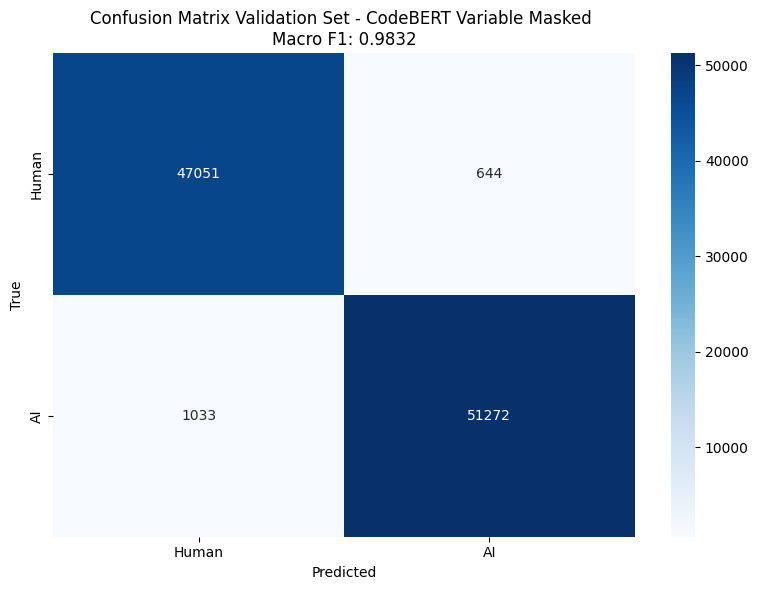

Confusion matrix saved


In [21]:
# CELL 18: CONFUSION MATRIX FOR VALIDATION SET


cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.title(f'Confusion Matrix Validation Set - CodeBERT Variable Masked \nMacro F1: {final_metrics["macro_f1"]:.4f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig(f"{Config.OUTPUT_DIR}/confusion_matrix.png", dpi=150)
plt.show()

print("Confusion matrix saved")

In [22]:
# CLASSIFICATION REPORT FOR VALIDATION SET

print("\nCLASSIFICATION REPORT FOR VALIDATION SET")
print(classification_report(true_labels, pred_labels,
                           target_names=['Human', 'AI'], digits=4))


CLASSIFICATION REPORT FOR VALIDATION SET
              precision    recall  f1-score   support

       Human     0.9785    0.9865    0.9825     47695
          AI     0.9876    0.9803    0.9839     52305

    accuracy                         0.9832    100000
   macro avg     0.9831    0.9834    0.9832    100000
weighted avg     0.9833    0.9832    0.9832    100000



Generating ROC curve
Probabilities calculated.
  Shape: (100000,)
  Example: 0.0001


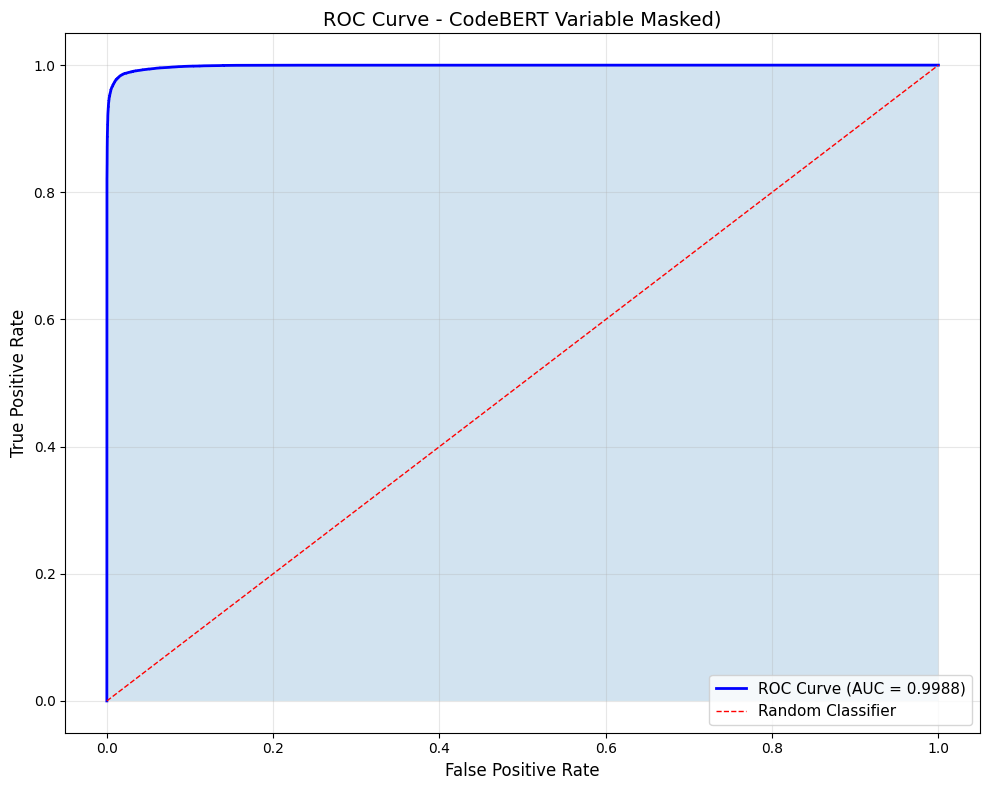

 ROC curve saved
  ROC-AUC: 0.9988


In [23]:
# GENERATE ROC CURVES

print("Generating ROC curve")
import torch

# 1. Get raw logits from the predictions object
pred_logits = predictions.predictions

# 2. Apply Softmax to convert logits to probabilities (0.0 to 1.0)
pred_probs = torch.softmax(torch.tensor(pred_logits), dim=1).numpy()

# 3. Extract the probability for AI class
pred_probs_ai = pred_probs[:, 1]

print("Probabilities calculated.")
print(f"  Shape: {pred_probs_ai.shape}")
print(f"  Example: {pred_probs_ai[0]:.4f}")
# Compute ROC curve
fpr, tpr, _ = roc_curve(true_labels, pred_probs_ai)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random Classifier')
plt.fill_between(fpr, tpr, alpha=0.2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - CodeBERT Variable Masked)', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{Config.OUTPUT_DIR}/roc_curve.png", dpi=150, bbox_inches='tight')
plt.show()

print(f" ROC curve saved")
print(f"  ROC-AUC: {roc_auc:.4f}")

Generating training history plots


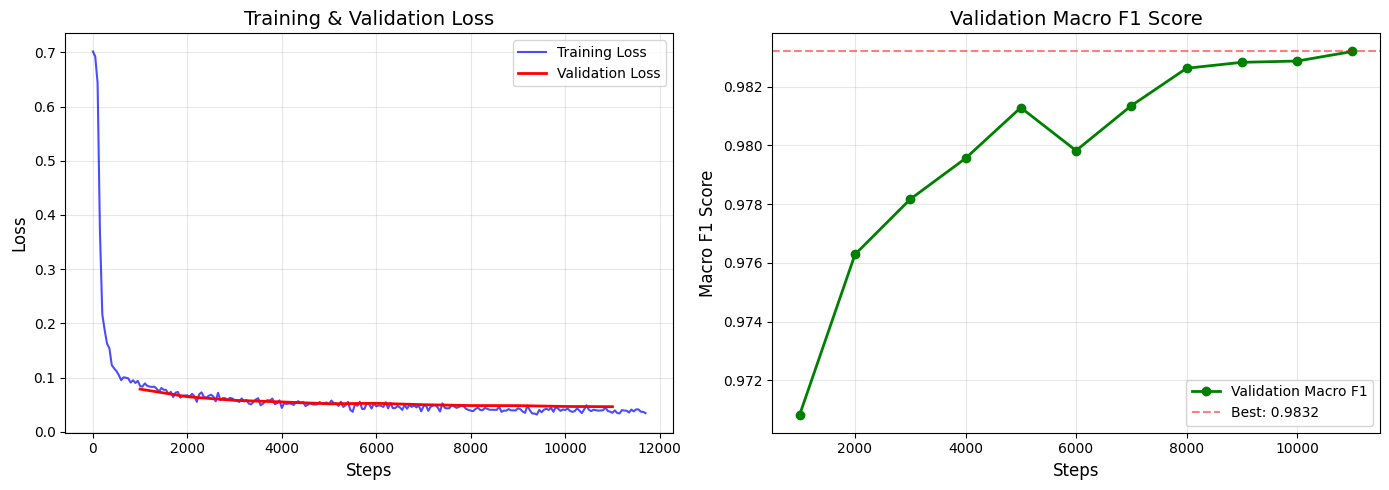

 Training history saved


In [24]:
# TRAINING HISTORY PLOTS

print("Generating training history plots")

# Get training history from trainer state
history = trainer.state.log_history

# Extract metrics
train_loss = [(h['step'], h['loss']) for h in history if 'loss' in h and 'eval_loss' not in h]
eval_metrics = [(h['step'], h.get('eval_loss'), h.get('eval_macro_f1'))
                for h in history if 'eval_loss' in h]

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss curves
ax1 = axes[0]
if train_loss:
    steps, losses = zip(*train_loss)
    ax1.plot(steps, losses, 'b-', alpha=0.7, label='Training Loss')
if eval_metrics:
    steps, eval_losses, _ = zip(*eval_metrics)
    eval_losses = [l for l in eval_losses if l is not None]
    if eval_losses:
        ax1.plot(steps[:len(eval_losses)], eval_losses, 'r-', linewidth=2, label='Validation Loss')
ax1.set_xlabel('Steps', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training & Validation Loss', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Macro F1 score
ax2 = axes[1]
if eval_metrics:
    steps, _, f1_scores = zip(*eval_metrics)
    f1_scores = [f for f in f1_scores if f is not None]
    if f1_scores:
        ax2.plot(steps[:len(f1_scores)], f1_scores, 'g-', linewidth=2, marker='o', label='Validation Macro F1')
        ax2.axhline(y=max(f1_scores), color='r', linestyle='--', alpha=0.5, label=f'Best: {max(f1_scores):.4f}')
ax2.set_xlabel('Steps', fontsize=12)
ax2.set_ylabel('Macro F1 Score', fontsize=12)
ax2.set_title('Validation Macro F1 Score', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{Config.OUTPUT_DIR}/training_history.png", dpi=150, bbox_inches='tight')
plt.show()

print(f" Training history saved")

In [25]:
# KAGGLE SUBMISSION

import pandas as pd
import numpy as np
import torch
from datasets import Dataset

TEST_FILE_PATH = "/content/test.parquet"

try:
    # 1. Load Test Data
    test_df = pd.read_parquet(TEST_FILE_PATH)
    print(f" Loaded test file: {len(test_df)} samples")
    print(f"  Columns: {test_df.columns.tolist()}")

    # 2. Detect ID column
    if 'ID' in test_df.columns:
        id_col_name = 'ID'
    elif 'id' in test_df.columns:
        id_col_name = 'id'
    else:
        id_col_name = test_df.columns[0]
    print(f"  Using ID column: '{id_col_name}'")

    # 3. Save original IDs
    test_ids = test_df[id_col_name].values

    # 4. Apply preprocessing
    print("Applying  preprocessing")

    def preprocess_test(code: str) -> str:
        """Same preprocessing as training - with variable masking."""

        # Remove comments
        code = re.sub(r'#.*$', '', code, flags=re.MULTILINE)
        code = re.sub(r'"""[\s\S]*?"""', '', code)
        code = re.sub(r"'''[\s\S]*?'''", '', code)
        code = re.sub(r'//.*$', '', code, flags=re.MULTILINE)
        code = re.sub(r'/\*[\s\S]*?\*/', '', code)

        # Remove imports
        code = re.sub(r'^import\s+.*$', '', code, flags=re.MULTILINE)
        code = re.sub(r'^from\s+\S+\s+import\s+.*$', '', code, flags=re.MULTILINE)
        code = re.sub(r'^#include\s*[<"].*?[>"].*$', '', code, flags=re.MULTILINE)
        code = re.sub(r'^using\s+.*?;', '', code, flags=re.MULTILINE)
        code = re.sub(r'^package\s+.*?;', '', code, flags=re.MULTILINE)
        code = re.sub(r'^require\s*[\(]?.*$', '', code, flags=re.MULTILINE)
        code = re.sub(r'^use\s+.*?;', '', code, flags=re.MULTILINE)

        # Mask strings
        code = re.sub(r'"(?:[^"\\]|\\.)*"', '"_S_"', code)
        code = re.sub(r"'(?:[^'\\]|\\.)*'", "'_S_'", code)
        code = re.sub(r'`(?:[^`\\]|\\.)*`', '`_S_`', code)

        # Mask numbers
        code = re.sub(r'\b\d+\.?\d*[fFdDlL]?\b', '_N_', code)

        # Mask variables
        keywords = {
            'def', 'class', 'if', 'else', 'elif', 'for', 'while', 'return',
            'import', 'from', 'as', 'try', 'except', 'finally', 'with',
            'lambda', 'yield', 'assert', 'pass', 'break', 'continue',
            'and', 'or', 'not', 'in', 'is', 'None', 'True', 'False',
            'global', 'nonlocal', 'raise', 'del', 'async', 'await',
            'int', 'float', 'double', 'char', 'void', 'bool', 'boolean',
            'long', 'short', 'unsigned', 'signed', 'const', 'static',
            'public', 'private', 'protected', 'struct', 'enum',
            'new', 'delete', 'this', 'super', 'null', 'nullptr',
            'switch', 'case', 'default', 'do', 'goto',
            'catch', 'throw', 'throws',
            'virtual', 'override', 'abstract', 'interface', 'extends',
            'implements', 'final', 'volatile', 'synchronized',
            'sizeof', 'typeof', 'instanceof', 'namespace',
            'extern', 'register', 'auto', 'inline', 'template',
            'true', 'false', 'string', 'String', 'var', 'let',
            'func', 'package', 'type', 'map', 'chan', 'go', 'select',
            'defer', 'range', 'make', 'append',
            'function', 'echo', 'print', 'array', 'foreach', 'endif',
            'endfor', 'endwhile', 'endforeach',
            'undefined', 'NaN', 'Infinity', 'constructor', 'prototype',
            'print', 'len', 'range', 'str', 'list', 'dict', 'set',
            'input', 'open', 'file', 'main', 'args', 'argv', 'self', 'cls',
            'printf', 'scanf', 'cout', 'cin', 'endl', 'std',
            'System', 'out', 'println', 'Math', 'Arrays', 'ArrayList',
            '_S_', '_N_', '_V_',
        }

        def replace_identifier(match):
            name = match.group(1)
            return name if name in keywords else '_V_'

        code = re.sub(r'\b([a-zA-Z_][a-zA-Z0-9_]*)\b', replace_identifier, code)

        # Clean whitespace
        lines = [line for line in code.split('\n') if line.strip()]
        code = '\n'.join(lines)

        return code.strip()

    test_df['code'] = test_df['code'].apply(preprocess_test)
    print("  preprocessing complete")

    # 5. Tokenize
    test_dataset = Dataset.from_pandas(test_df[[id_col_name, 'code']])

    def tokenize_test(examples):
        return tokenizer(
            examples['code'],
            truncation=True,
            padding='max_length',
            max_length=512,
            return_tensors=None,
        )

    tokenized_test = test_dataset.map(
        tokenize_test,
        batched=True,
        num_proc=4,
        remove_columns=['code', id_col_name],
        desc="Tokenizing test"
    )
    tokenized_test.set_format('torch')

    # 6. Get predictions
    print("Running inference")
    test_predictions = trainer.predict(tokenized_test)

    # Standard argmax prediction
    test_pred_labels = np.argmax(test_predictions.predictions, axis=1)

    print(f"\nPrediction distribution:")
    print(f"  Human (0): {(test_pred_labels == 0).sum()} ({(test_pred_labels == 0).mean()*100:.1f}%)")
    print(f"  AI (1):    {(test_pred_labels == 1).sum()} ({(test_pred_labels == 1).mean()*100:.1f}%)")

    # 7. Create submission
    submission_df = pd.DataFrame({
        'ID': test_ids,
        'label': test_pred_labels
    })

    # Save
    submission_path = f"{Config.OUTPUT_DIR}/submission.csv"
    submission_df.to_csv(submission_path, index=False)

    print(f"\n Submission saved to: {submission_path}")
    print(f"\nPreview:")
    print(submission_df.head(10))

except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()

 Loaded test file: 1000 samples
  Columns: ['ID', 'code']
  Using ID column: 'ID'
Applying  preprocessing
  preprocessing complete


Tokenizing test (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Running inference



Prediction distribution:
  Human (0): 182 (18.2%)
  AI (1):    818 (81.8%)

 Submission saved to: ./codebert_varmasking/submission.csv

Preview:
      ID  label
0   2005      1
1   2384      0
2   3526      0
3   3926      0
4   7222      1
5   7420      0
6   9627      1
7   9859      0
8  11611      0
9  11631      1


 GENERATING APPENDIX FIGURES FROM: /content/test_sample.parquet
   Loaded 1000 samples.
   Applying preprocessing


Tokenizing sample (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

   Running inference on test sample


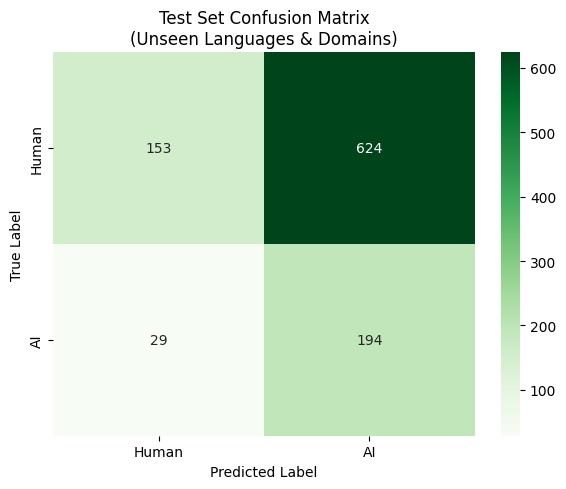

    Saved Test Confusion Matrix

   Generating Precision-Recall Curves


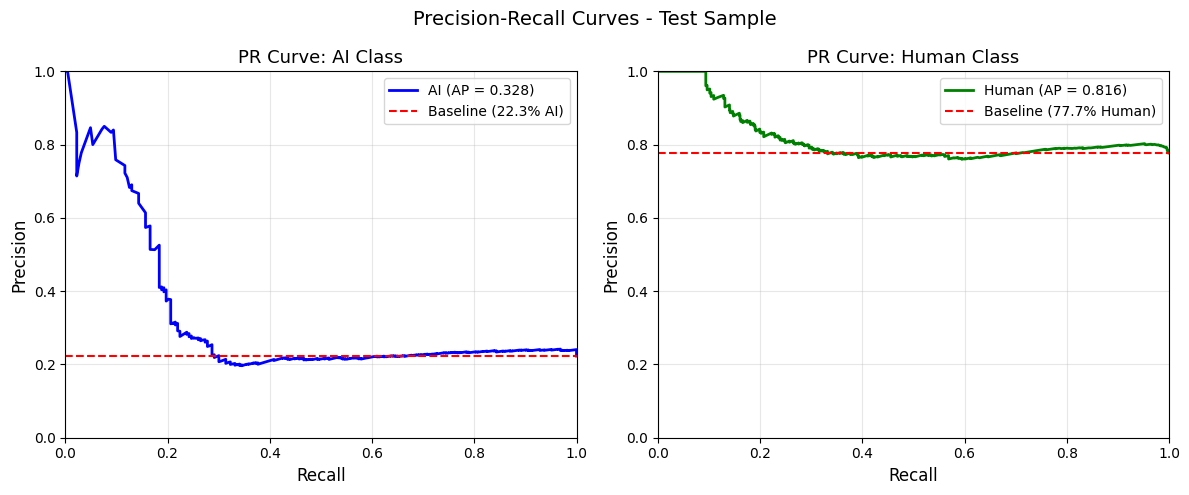

    Saved PR Curves (AP_AI=0.328, AP_Human=0.816)

   Generating Language Generalization Plot


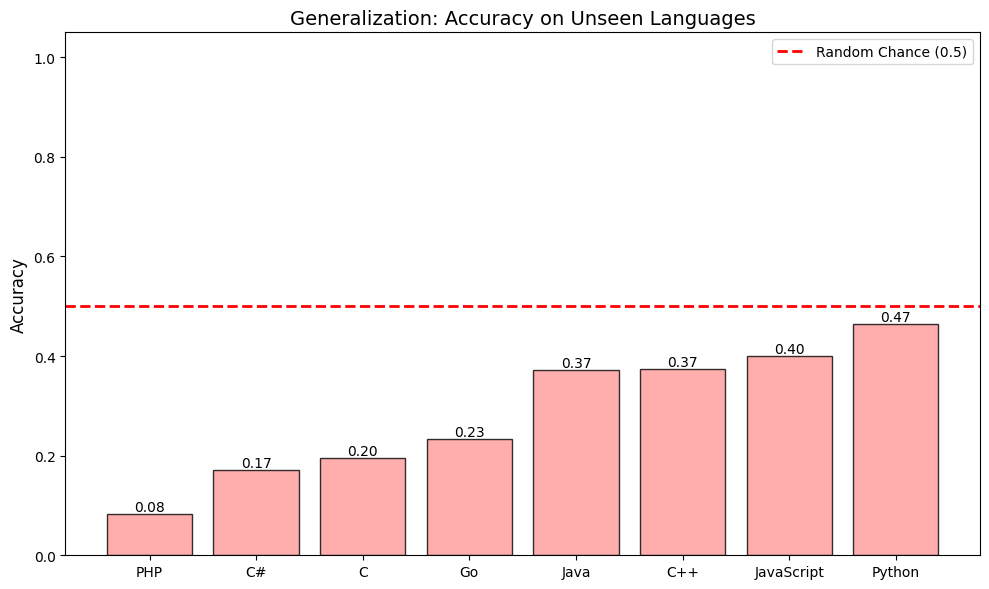

    Saved Generalization Plot

 TEST SAMPLE CLASSIFICATION REPORT
              precision    recall  f1-score   support

       Human     0.8407    0.1969    0.3191       777
          AI     0.2372    0.8700    0.3727       223

    accuracy                         0.3470      1000
   macro avg     0.5389    0.5334    0.3459      1000
weighted avg     0.7061    0.3470    0.3310      1000



In [29]:
# VISUALIZATIONS FOR APPENDIX

import pandas as pd
import numpy as np
import torch
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score
)

# 1. Configuration
TEST_SAMPLE_PATH = "/content/test_sample.parquet"

print(f" GENERATING APPENDIX FIGURES FROM: {TEST_SAMPLE_PATH}")

try:
    # 2. Load the Labeled Test Sample
    test_sample = pd.read_parquet(TEST_SAMPLE_PATH)
    print(f"   Loaded {len(test_sample)} samples.")

    # Check if  columns exist
    if 'label' not in test_sample.columns:
        raise ValueError("Dataset is missing 'label' column. Cannot generate evaluation metrics.")

    # 3. Preprocess
    print("   Applying preprocessing")
    if 'preprocess_test' in locals():
        test_sample['code'] = test_sample['code'].apply(preprocess_test)


    # 4. Tokenize
    sample_dataset = Dataset.from_pandas(test_sample[['code', 'label']])

    def tokenize_sample(examples):
        return tokenizer(
            examples['code'],
            truncation=True,
            padding='max_length',
            max_length=512
        )

    tokenized_sample = sample_dataset.map(
        tokenize_sample,
        batched=True,
        num_proc=4,
        remove_columns=['code'],
        desc="Tokenizing sample"
    )
    tokenized_sample.set_format('torch')

    # 5. Predict
    print("   Running inference on test sample")
    sample_preds = trainer.predict(tokenized_sample)
    pred_labels = np.argmax(sample_preds.predictions, axis=1)
    true_labels = test_sample['label'].values

    # Get probabilities for PR curve
    pred_probs = torch.softmax(torch.tensor(sample_preds.predictions), dim=1).numpy()
    prob_ai = pred_probs[:, 1]

    # FIGURE A: TEST CONFUSION MATRIX
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
    plt.title('Test Set Confusion Matrix\n(Unseen Languages & Domains)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f"{Config.OUTPUT_DIR}/confusion_matrix_test.png", dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved Test Confusion Matrix")

    # FIGURE B: PRECISION-RECALL CURVES
    print("\n   Generating Precision-Recall Curves")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # AI Class (Class 1)
    precision_ai, recall_ai, _ = precision_recall_curve(true_labels, prob_ai)
    ap_ai = average_precision_score(true_labels, prob_ai)

    axes[0].plot(recall_ai, precision_ai, 'b-', linewidth=2, label=f'AI (AP = {ap_ai:.3f})')
    axes[0].axhline(y=0.223, color='r', linestyle='--', label='Baseline (22.3% AI)')
    axes[0].set_xlabel('Recall', fontsize=12)
    axes[0].set_ylabel('Precision', fontsize=12)
    axes[0].set_title('PR Curve: AI Class', fontsize=13)
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim([0, 1])
    axes[0].set_ylim([0, 1])

    # Human Class (Class 0)
    prob_human = 1 - prob_ai
    true_human = 1 - true_labels
    precision_h, recall_h, _ = precision_recall_curve(true_human, prob_human)
    ap_h = average_precision_score(true_human, prob_human)

    axes[1].plot(recall_h, precision_h, 'g-', linewidth=2, label=f'Human (AP = {ap_h:.3f})')
    axes[1].axhline(y=0.777, color='r', linestyle='--', label='Baseline (77.7% Human)')
    axes[1].set_xlabel('Recall', fontsize=12)
    axes[1].set_ylabel('Precision', fontsize=12)
    axes[1].set_title('PR Curve: Human Class', fontsize=13)
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim([0, 1])
    axes[1].set_ylim([0, 1])

    plt.suptitle('Precision-Recall Curves - Test Sample', fontsize=14)
    plt.tight_layout()
    plt.savefig(f"{Config.OUTPUT_DIR}/pr_curve_test.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"    Saved PR Curves (AP_AI={ap_ai:.3f}, AP_Human={ap_h:.3f})")

    # FIGURE C: GENERALIZATION BY LANGUAGE

    if 'language' in test_sample.columns:
        print("\n   Generating Language Generalization Plot")
        test_sample['predicted'] = pred_labels
        test_sample['correct'] = (test_sample['label'] == test_sample['predicted'])

        lang_acc = test_sample.groupby('language')['correct'].mean().sort_values()
        colors = ['#ff9999' if x < 0.5 else '#66b3ff' for x in lang_acc.values]

        plt.figure(figsize=(10, 6))
        bars = plt.bar(lang_acc.index, lang_acc.values, color=colors, edgecolor='black', alpha=0.8)
        plt.axhline(0.5, color='red', linestyle='--', linewidth=2, label='Random Chance (0.5)')

        plt.title('Generalization: Accuracy on Unseen Languages', fontsize=14)
        plt.ylabel('Accuracy', fontsize=12)
        plt.ylim(0, 1.05)
        plt.bar_label(bars, fmt='%.2f')
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"{Config.OUTPUT_DIR}/language_generalization_test.png", dpi=150, bbox_inches='tight')
        plt.show()
        print("    Saved Generalization Plot")

    # CLASSIFICATION REPORT
    print("\n TEST SAMPLE CLASSIFICATION REPORT")
    print(classification_report(true_labels, pred_labels, target_names=['Human', 'AI'], digits=4))

except Exception as e:
    print(f" Error: {e}")